Over the last few months I have developed an interest in analyzing data about Lego sets, primarily scraped from the excellent community resource [Brickset](https://brickset.com/).  Until now I have focused on price, with one [empirical analysis](https://austinrochford.com/posts/2021-06-03-vader-meditation.html) and two [Bayesian](https://austinrochford.com/posts/2021-06-10-lego-pymc3.html) [analyses](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html) of the factors that drive Lego set prices, fairness of the pricing of certain notable sets ([75296](https://www.lego.com/en-us/product/darth-vader-meditation-chamber-75296) and [75309](https://www.lego.com/en-us/product/republic-gunship-75309)), and whether I tend to collect over- or under-priced sets.

In this post I will change that focus to understanding what factors affect the ratings given to each set by Brickset members.  Given my particular interest in Star Wars sets (they comprise the overwhelming majority of my collection), I am specifically curious if there is any relationship between the critical and popular reception of individual Star Wars films and television series and the Lego sets associated with them.

First we make the necessary Python imports and do some light housekeeping.

In [1]:
%matplotlib inline

In [2]:
import datetime
from functools import reduce
from warnings import filterwarnings

In [3]:
import arviz as az
from aesara import shared, tensor as at
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
import networkx as nx
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xarray as xr

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


In [4]:
filterwarnings('ignore', category=RuntimeWarning, module='aesara')
filterwarnings('ignore', category=UserWarning, module='arviz')
filterwarnings('ignore', category=FutureWarning, module='pymc')

In [5]:
FIG_WIDTH = 8
FIG_HEIGHT = 6
mpl.rcParams['figure.figsize'] = (FIG_WIDTH, FIG_HEIGHT)

sns.set(color_codes=True)

pct_formatter = StrMethodFormatter('{x:.1%}')

## Load the data

We begin the real work by loading the data scraped from Brickset. See the [first post](https://austinrochford.com/posts/2021-06-03-vader-meditation.html) in this series for more background on the data.  Note that in addition to the data present in previous scrapes we have added the count of star ratings `'✭'`, `'✭✭'`,`'✭✭✭'`, `'✭✭✭✭'`, and `'✭✭✭✭✭'` for each set that has ratings available.

In [6]:
DATA_URI = 'https://austinrochford.com/resources/lego/brickset_19800101_20210922.csv.gz'

In [7]:
def to_year(x):
    return np.int64(round(x))

In [8]:
ATTR_COLS = [
    'Set number', 'Name', 'Set type', 'Year released',
    'Theme', 'Subtheme', 'Pieces', 'RRP$'
]
RATING_COLS = ['✭', '✭✭','✭✭✭', '✭✭✭✭', '✭✭✭✭✭']

ALL_COLS = ATTR_COLS + RATING_COLS

In [9]:
full_df = (pd.read_csv(DATA_URI, usecols=ALL_COLS)
             [ALL_COLS]
             .dropna(subset=set(ATTR_COLS) - {"Subtheme"}))
full_df["Year released"] = full_df["Year released"].apply(to_year)
full_df["Subtheme"] = full_df["Subtheme"].fillna("None")
full_df = (full_df.sort_values(["Year released", "Set number"])
                  .set_index("Set number"))

We see that the data set contains information on approximately 8,600 Lego sets produced between 1980 and September 2021.

In [10]:
full_df

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭
Set number,,,,,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,1980,Dacta,None,68.0,36.50,NaN,NaN,NaN,NaN,NaN
1075-1,LEGO People Supplementary Set,Normal,1980,Dacta,None,304.0,14.50,NaN,NaN,NaN,NaN,NaN
1101-1,Replacement 4.5V Motor,Normal,1980,Service Packs,None,1.0,5.65,NaN,NaN,NaN,NaN,NaN
1123-1,Ball and Socket Couplings & One Articulated Joint,Normal,1980,Service Packs,None,8.0,16.00,NaN,NaN,NaN,NaN,NaN
1130-1,Plastic Folder for Building Instructions,Normal,1980,Service Packs,None,1.0,14.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80025-1,Sandy's Power Loader Mech,Normal,2021,Monkie Kid,Season 2,520.0,54.99,NaN,NaN,NaN,NaN,NaN
80026-1,Pigsy's Noodle Tank,Normal,2021,Monkie Kid,Season 2,662.0,59.99,NaN,NaN,NaN,NaN,NaN
80028-1,The Bone Demon,Normal,2021,Monkie Kid,Season 2,1375.0,119.99,NaN,NaN,NaN,NaN,NaN


In [11]:
full_df.describe()

,Year released,Pieces,RRP$,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭
count,8632.000000,8632.000000,8632.000000,5025.000000,5476.000000,5667.000000,5694.000000,5693.000000
mean,2009.286376,263.574490,31.667443,4.649154,8.555698,19.518087,30.423077,45.170912
std,9.030748,489.757624,45.678743,4.126446,7.975121,18.917916,32.934498,62.309390
min,1980.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2003.000000,32.000000,7.000000,2.000000,3.000000,7.000000,11.000000,13.000000
50%,2012.000000,100.000000,18.000000,3.000000,6.000000,14.000000,20.000000,27.000000
75%,2017.000000,305.000000,39.990000,6.000000,11.000000,26.000000,37.750000,52.000000
max,2021.000000,11695.000000,799.990000,46.000000,96.000000,228.000000,361.000000,1080.000000


As in previous posts, we adjust `RRP` (recommended retail price) to 2021 dollars.

In [12]:
CPI_URL = 'https://austinrochford.com/resources/lego/CPIAUCNS202100401.csv'

In [13]:
years = pd.date_range('1979-01-01', '2021-01-01', freq='Y') \
        + datetime.timedelta(days=1)
cpi_df = (pd.read_csv(CPI_URL, index_col="DATE", parse_dates=["DATE"])
            .loc[years])
cpi_df["to2021"] = cpi_df.loc["2021-01-01"] / cpi_df
cpi_df["year"] = cpi_df.index.year

In [14]:
cpi_df.head()

,CPIAUCNS,to2021,year
DATE,,,
1980-01-01,77.8,3.362237,1980
1981-01-01,87.0,3.006690,1981
1982-01-01,94.3,2.773934,1982
1983-01-01,97.8,2.674663,1983
1984-01-01,101.9,2.567046,1984


In [15]:
pd.merge(full_df, cpi_df,
         left_on="Year released",
         right_on="year")

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭,CPIAUCNS,to2021,year
0,Educational Duplo Building Set,Normal,1980,Dacta,None,68.0,36.50,NaN,NaN,NaN,NaN,NaN,77.800,3.362237,1980
1,LEGO People Supplementary Set,Normal,1980,Dacta,None,304.0,14.50,NaN,NaN,NaN,NaN,NaN,77.800,3.362237,1980
2,Replacement 4.5V Motor,Normal,1980,Service Packs,None,1.0,5.65,NaN,NaN,NaN,NaN,NaN,77.800,3.362237,1980
3,Ball and Socket Couplings & One Articulated Joint,Normal,1980,Service Packs,None,8.0,16.00,NaN,NaN,NaN,NaN,NaN,77.800,3.362237,1980
4,Plastic Folder for Building Instructions,Normal,1980,Service Packs,None,1.0,14.00,NaN,NaN,NaN,NaN,NaN,77.800,3.362237,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8627,Sandy's Power Loader Mech,Normal,2021,Monkie Kid,Season 2,520.0,54.99,NaN,NaN,NaN,NaN,NaN,261.582,1.000000,2021
8628,Pigsy's Noodle Tank,Normal,2021,Monkie Kid,Season 2,662.0,59.99,NaN,NaN,NaN,NaN,NaN,261.582,1.000000,2021
8629,The Bone Demon,Normal,2021,Monkie Kid,Season 2,1375.0,119.99,NaN,NaN,NaN,NaN,NaN,261.582,1.000000,2021
8630,Story of Nian,Normal,2021,Seasonal,Chinese Traditional Festivals,1067.0,79.99,NaN,2.0,2.0,11.0,14.0,261.582,1.000000,2021


In [16]:
full_df.insert(len(ATTR_COLS) - 1,
               "RRP2021",
               (pd.merge(full_df, cpi_df,
                         left_on="Year released",
                         right_on="year")
                   .apply(lambda df: (df["RRP$"] * df["to2021"]),
                          axis=1))
                   .values)

In [17]:
full_df.head()

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭
Set number,,,,,,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,1980,Dacta,None,68.0,36.50,122.721632,NaN,NaN,NaN,NaN,NaN
1075-1,LEGO People Supplementary Set,Normal,1980,Dacta,None,304.0,14.50,48.752429,NaN,NaN,NaN,NaN,NaN
1101-1,Replacement 4.5V Motor,Normal,1980,Service Packs,None,1.0,5.65,18.996636,NaN,NaN,NaN,NaN,NaN
1123-1,Ball and Socket Couplings & One Articulated Joint,Normal,1980,Service Packs,None,8.0,16.00,53.795784,NaN,NaN,NaN,NaN,NaN
1130-1,Plastic Folder for Building Instructions,Normal,1980,Service Packs,None,1.0,14.00,47.071311,NaN,NaN,NaN,NaN,NaN


We also add a column indicating whether or not I own each set.

In [18]:
AUSTIN_URI = 'https://austinrochford.com/resources/lego/Brickset-MySets-owned-20211002.csv'

In [19]:
austin_sets = set(
    pd.read_csv(AUSTIN_URI, usecols=["Number"])
      .values
      .squeeze()
)

In [20]:
full_df["Austin owns"] = (full_df.index
                                 .get_level_values("Set number")
                                 .isin(austin_sets))

In [21]:
full_df.head()

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭,Austin owns
Set number,,,,,,,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,1980,Dacta,None,68.0,36.50,122.721632,NaN,NaN,NaN,NaN,NaN,False
1075-1,LEGO People Supplementary Set,Normal,1980,Dacta,None,304.0,14.50,48.752429,NaN,NaN,NaN,NaN,NaN,False
1101-1,Replacement 4.5V Motor,Normal,1980,Service Packs,None,1.0,5.65,18.996636,NaN,NaN,NaN,NaN,NaN,False
1123-1,Ball and Socket Couplings & One Articulated Joint,Normal,1980,Service Packs,None,8.0,16.00,53.795784,NaN,NaN,NaN,NaN,NaN,False
1130-1,Plastic Folder for Building Instructions,Normal,1980,Service Packs,None,1.0,14.00,47.071311,NaN,NaN,NaN,NaN,NaN,False


Based on the exploratory data analysis in the first post in this series, we filter full_df down to approximately 6,400 sets to be considered for analysis.

In [22]:
FILTERS = [
    full_df["Set type"] == "Normal",
    full_df["Pieces"] > 10,
    full_df["Theme"] != "Duplo",
    full_df["Theme"] != "Service Packs",
    full_df["Theme"] != "Bulk Bricks",
    full_df["RRP2021"] > 0
]

In [23]:
df = full_df[reduce(np.logical_and, FILTERS)].copy()

In [24]:
df

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭,Austin owns
Set number,,,,,,,,,,,,,,
1041-2,Educational Duplo Building Set,Normal,1980,Dacta,None,68.0,36.50,122.721632,NaN,NaN,NaN,NaN,NaN,False
1075-1,LEGO People Supplementary Set,Normal,1980,Dacta,None,304.0,14.50,48.752429,NaN,NaN,NaN,NaN,NaN,False
5233-1,Bedroom,Normal,1980,Homemaker,None,26.0,4.50,15.130064,NaN,NaN,NaN,NaN,NaN,False
6305-1,Trees and Flowers,Normal,1980,Town,Accessories,12.0,3.75,12.608387,3.0,4.0,9.0,6.0,13.0,False
6306-1,Road Signs,Normal,1980,Town,Accessories,12.0,2.50,8.405591,4.0,2.0,8.0,13.0,17.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80025-1,Sandy's Power Loader Mech,Normal,2021,Monkie Kid,Season 2,520.0,54.99,54.990000,NaN,NaN,NaN,NaN,NaN,False
80026-1,Pigsy's Noodle Tank,Normal,2021,Monkie Kid,Season 2,662.0,59.99,59.990000,NaN,NaN,NaN,NaN,NaN,False
80028-1,The Bone Demon,Normal,2021,Monkie Kid,Season 2,1375.0,119.99,119.990000,NaN,NaN,NaN,NaN,NaN,False


In [25]:
df.describe()

,Year released,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭
count,6420.000000,6420.000000,6420.000000,6420.000000,4307.000000,4712.000000,4883.000000,4907.000000,4906.000000
mean,2009.714642,343.184112,37.552062,46.171183,4.636638,8.516978,19.449928,31.193397,46.018956
std,8.939369,544.179590,50.379534,59.373029,4.273900,8.313056,19.843605,34.925100,66.244232
min,1980.000000,11.000000,0.600000,0.971220,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2003.000000,69.000000,9.990000,11.870620,2.000000,3.000000,7.000000,10.000000,13.000000
50%,2012.000000,181.000000,19.990000,27.347055,3.000000,6.000000,13.000000,19.000000,25.000000
75%,2017.000000,404.000000,49.990000,56.497192,6.000000,11.000000,25.000000,38.000000,52.000000
max,2021.000000,11695.000000,799.990000,897.373477,46.000000,96.000000,228.000000,361.000000,1080.000000


We now reduce `df` to sets that have had at least one rating.

In [26]:
rated_df = df.dropna(how='all', subset=RATING_COLS).copy()
rated_df[RATING_COLS] = rated_df[RATING_COLS].fillna(0.)
rated_df["Ratings"] = rated_df[RATING_COLS].sum(axis=1)

In [27]:
rated_df.head()

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭,Austin owns,Ratings
Set number,,,,,,,,,,,,,,,
6305-1,Trees and Flowers,Normal,1980,Town,Accessories,12.0,3.75,12.608387,3.0,4.0,9.0,6.0,13.0,False,35.0
6306-1,Road Signs,Normal,1980,Town,Accessories,12.0,2.50,8.405591,4.0,2.0,8.0,13.0,17.0,False,44.0
6375-2,Exxon Gas Station,Normal,1980,Town,Shops and Services,267.0,20.00,67.244730,0.0,0.0,1.0,5.0,12.0,False,18.0
6390-1,Main Street,Normal,1980,Town,Shops and Services,591.0,40.00,134.489460,0.0,1.0,1.0,3.0,14.0,False,19.0
6861-1,X1 Patrol Craft,Normal,1980,Space,Classic,55.0,4.00,13.448946,1.0,3.0,6.0,14.0,19.0,False,43.0


We see that slightly more than 75% of the sets under consideration have at least one rating, which is (pleasantly) more than I was expecting.

In [28]:
rated_df.shape[0] / df.shape[0]

0.7643302180685358

## Exploratory Data Analysis

We begin with a descriptive exploration of the Brickset ratings data.  Immediately we see that the vast majority of sets have been rated a few dozen to a few hundred times.

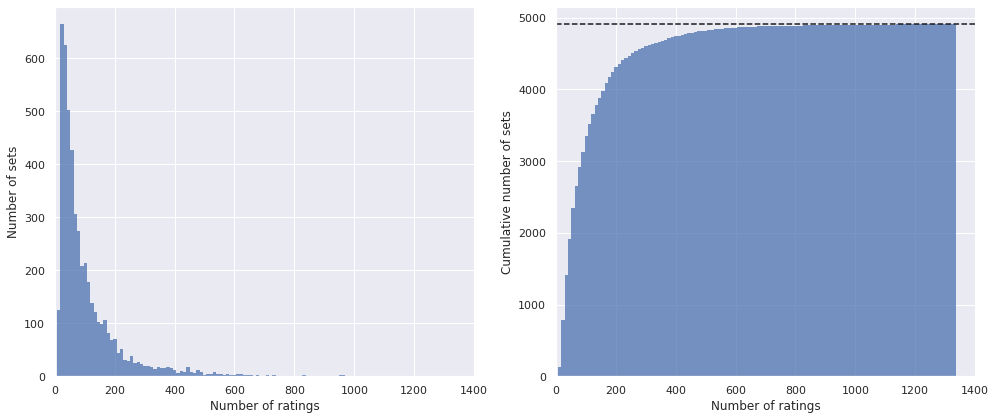

In [29]:
fig, axes = plt.subplots(ncols=2, sharex=True,
                         figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT))

sns.histplot(rated_df[RATING_COLS].sum(axis=1),
             lw=0., ax=axes[0])

axes[0].set_xlim(left=0);
axes[0].set_xlabel("Number of ratings");

axes[0].set_ylabel("Number of sets");

sns.histplot(rated_df[RATING_COLS].sum(axis=1),
             cumulative=True, lw=0., ax=axes[1])
axes[1].axhline(rated_df.shape[0], c='k', ls='--');

axes[1].set_xlim(left=0);
axes[1].set_xlabel("Number of ratings");

axes[1].set_ylabel("Cumulative number of sets");

fig.tight_layout();

We now explore the distribution of average ratings.

In [30]:
def average_rating(ratings):
    if isinstance(ratings, (xr.DataArray, xr.Dataset)):
        stars = ratings.coords["rating"].str.len()

        return (ratings * stars).sum(dim="rating") / ratings.sum(dim="rating")
    else:
        ratings = np.asanyarray(ratings)
        stars = 1 + np.arange(ratings.shape[-1])

        return (ratings * stars).sum(axis=-1) / ratings.sum(axis=-1)

In [31]:
rated_df["Average rating"] = (rated_df[RATING_COLS]
                                      .apply(average_rating, axis=1))

We see that the distribution over time (our data set covers sets released between 1980 and September 2021) has decreased from just under 4.5 to just below 4 over the years.  Unsurprisingly, the percentage of ratings in each category between one and five stars has varied similarly over time.

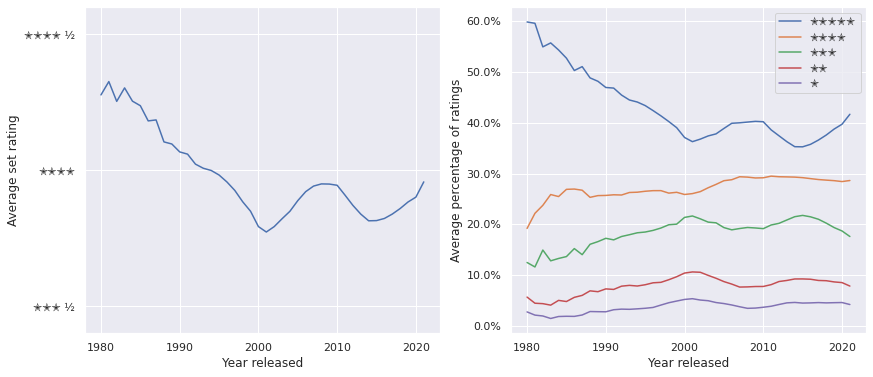

In [32]:
time_fig, axes = plt.subplots(
    ncols=2, sharex=True,
    figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT)
)

(rated_df["Average rating"]
         .groupby(rated_df["Year released"])
         .mean()
         .rolling(5, min_periods=1)
         .mean()
         .plot(ax=axes[0]));

axes[0].set_ylim(3.4, 4.6);
axes[0].set_yticks([3.5, 4, 4.5]);
axes[0].set_yticklabels(["✭✭✭ ½", "✭✭✭✭", "✭✭✭✭ ½"]);
axes[0].set_ylabel("Average set rating");

(rated_df[RATING_COLS]
         .div(rated_df[RATING_COLS].sum(axis=1),
              axis=0)
         .groupby(rated_df["Year released"])
         .mean()
         .rolling(5, min_periods=1)
         .mean()
         .iloc[:, ::-1]
         .plot(ax=axes[1]));

axes[1].yaxis.set_major_formatter(pct_formatter);
axes[1].set_ylabel("Average percentage of ratings");

It is interesting to try to interpret this trend.  Since the year is the year the set was released and not necessarily reviewed (Brickset [did not exist](https://brickset.com/article/52659/about-brickset) until 1997), there is certainly some selection bias in early reviews, because they will only exist for those Lego collectors sufficiently passionate to own older sets, join Brickset, and rate them there once the set becomes available.  In fact, for any period of time it is important to remember that these ratings do not represent the sentiment of the general Lego purchasing or collecting public towards each set, but the sentiments of the subset of those purchasers and collectors that are not only movitated to visit and join Brickset, but to rate their sets there.  For reference, I visit Bricket frequently for both research purposes and to track my collection, but I have never rated a set there.  It seems reasonable to assume that these biases will shrink, but never truly vanish, for more recently released sets.  These biases and caveats are important to keep in the back of our mind as we perform our analysis.

We now turn to the specific (sub)themes that I tend to collect, namely Star Wars and NASA sets.

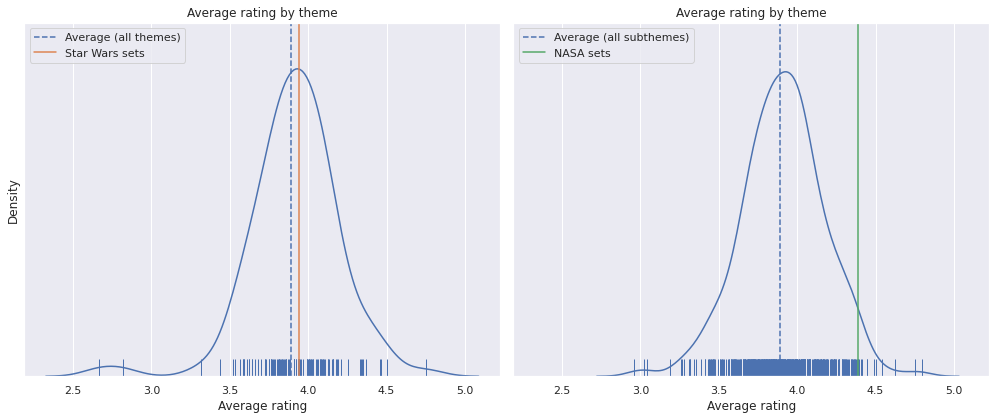

In [33]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT))

# Theme
sns.kdeplot(
    rated_df.groupby("Theme")
            ["Average rating"]
            .mean(),
    ax=axes[0]
);
sns.rugplot(
    rated_df.groupby("Theme")
            ["Average rating"]
            .mean(),
    height=0.05, c='C0', ax=axes[0]
);
axes[0].axvline(
    rated_df["Average rating"]
            .mean(),
    ls='--', label="Average (all themes)"
);
axes[0].axvline(
    rated_df[rated_df["Theme"] == "Star Wars"]
            ["Average rating"]
            .mean(),
    color='C1', label="Star Wars sets"
);

axes[0].set_yticks([]);
axes[0].legend(loc='upper left');
axes[0].set_title("Average rating by theme");

# Subtheme
sns.kdeplot(
    rated_df.groupby("Subtheme")
            ["Average rating"]
            .mean(),
    ax=axes[1]
);
sns.rugplot(
    rated_df.groupby("Subtheme")
            ["Average rating"]
            .mean(),
    height=0.05, c='C0', ax=axes[1]
);
axes[1].axvline(
    rated_df["Average rating"]
            .mean(),
    ls='--', label="Average (all subthemes)"
);
axes[1].axvline(
    rated_df[rated_df["Subtheme"] == "NASA"]
            ["Average rating"]
            .mean(),
    color='C2', label="NASA sets"
);

axes[1].legend(loc='upper left');
axes[1].set_title("Average rating by theme");

fig.tight_layout();

We see that the average rating for Star Wars sets is close to the average rating of all sets, whereas the averating rating for NASA sets is significantly higher than the average rating for all sets.  I am not surprised that NASA sets score so highly ([21309](https://brickset.com/sets/21309-1/NASA-Apollo-Saturn-V), [10266](https://brickset.com/sets/10266-1/NASA-Apollo-11-Lunar-Lander), [10283](https://brickset.com/sets/10283-1/NASA-Space-Shuttle-Discovery), and [21312](https://brickset.com/sets/21312-1/Women-of-NASA)) are some of my favorite sets, but I am a bit surprised to find that Star Wars, as an overall theme, is as middle-of-the-road as it is.  Even restricting to the period after 1999 (when Star Wars sets started to be released), this phenomenon persists.

In [34]:
star_wars_min_year = (rated_df[rated_df["Theme"] == "Star Wars"]
                              ["Year released"]
                              .min())

In [35]:
star_wars_min_year

1999

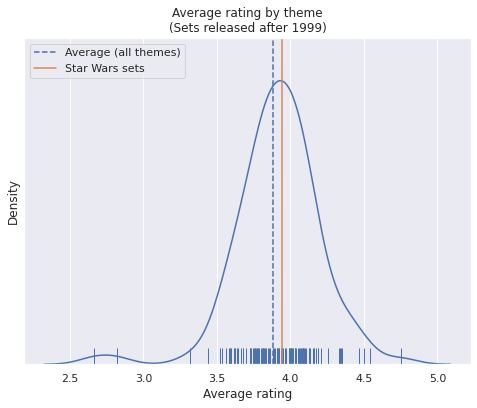

In [36]:
ax = sns.kdeplot(
    rated_df.groupby("Theme")
            ["Average rating"]
            .mean(),
)
sns.rugplot(
    rated_df[rated_df["Year released"] >= star_wars_min_year]
            .groupby("Theme")
            ["Average rating"]
            .mean(),
    height=0.05, c='C0', ax=ax
);
ax.axvline(
    rated_df[rated_df["Year released"] >= star_wars_min_year]
            ["Average rating"]
            .mean(),
    ls='--', label="Average (all themes)"
);
ax.axvline(
    rated_df[rated_df["Theme"] == "Star Wars"]
            ["Average rating"]
            .mean(),
    color='C1', label="Star Wars sets"
);

ax.set_yticks([]);
ax.legend(loc='upper left');
ax.set_title(f"Average rating by theme\n(Sets released after {star_wars_min_year})");

Our subsequent analysis will attempt to control for both the year a set was released and other factors (piece count and price) more rigorously in order to see if this phenomenon persists.

Turning to piece count and price, we see that a positive, fairly linear relationship between both of these characteristics and average rating.

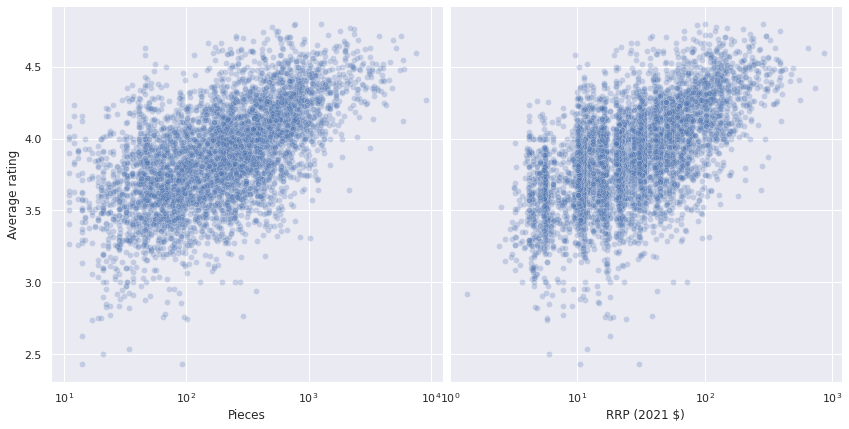

In [37]:
pieces_price_grid = sns.pairplot(rated_df,
                    x_vars=["Pieces", "RRP2021"],
                    y_vars=["Average rating"],
                    plot_kws={'alpha': 0.25},
                    height=FIG_HEIGHT)

for ax in pieces_price_grid.axes.flat:
    ax.set_xscale('log');
    
pieces_price_grid.axes[0, 1].set_xlabel("RRP (2021 $)");

It is interesting to consider the causal nature of the relationship between piece count, price, and ratings.  Clearly larger sets requiring more pieces have higher production costs and therefore higher retail prices.  Higher priced sets probably also have to be of a better overall quality in order to justify the significant expense. I personally occasionally buy cheaper sets that I don't love if they have interesting components.  I purchased [75299](https://brickset.com/sets/75299-1/Trouble-on-Tatooine) just to get Mando and the Child riding a speeder together (the rest of the bags went straight into my spare parts bin).

<center>
    <img src="https://images.brickset.com/sets/AdditionalImages/75299-1/75299_alt1.jpg" width=500>
</center>

Based on this discussion, the causal DAG for the relationship between piece count, price, and rating is as follows.

In [38]:
graph = nx.DiGraph()
graph.add_edges_from([
    ("Piece count", "Price"),
    ("Piece count", "Rating"),
    ("Price", "Rating")
])

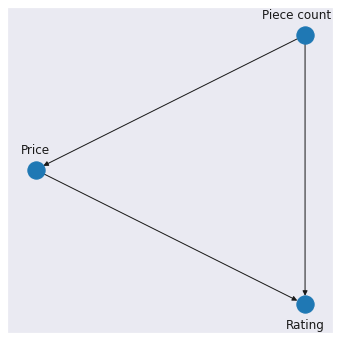

In [39]:
fig, ax = plt.subplots()

POS = {
    "Piece count": (1, 1),
    "Price": (0, 0.5),
    "Rating": (1, 0)
}
LABEL_POS = {
    "Piece count": (0.97, 1.075),
    "Price": (0, 0.575),
    "Rating": (1, -0.075)
}

nx.draw_networkx_nodes(graph, pos=POS, ax=ax);
nx.draw_networkx_edges(graph, pos=POS, ax=ax);
nx.draw_networkx_labels(graph, pos=LABEL_POS, ax=ax);

ax.set_xticks([]);
ax.set_yticks([]);
ax.set_aspect('equal');

This discussion of causality is certainly interesting and may be worth future exploration, but we will not take the causal perspective for the rest of this post.  Rather, our models will be interpreted descriptively, as tools that help us summarize the ratings of various groups of Lego sets.

We conclude our exploratory data analysis by seeing where the ratings of the sets I own fall in the distribution of all rated sets.  It appears that most of my sets are rated above average, because, of course, I have excellent taste.

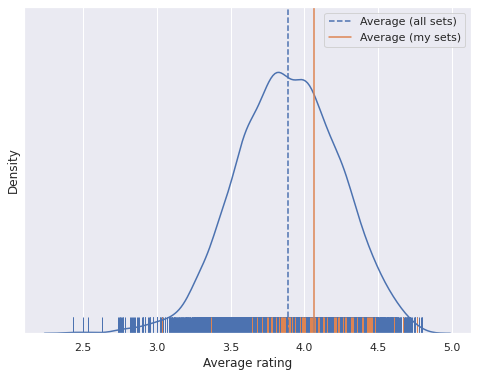

In [40]:
ax = sns.kdeplot(rated_df["Average rating"])

sns.rugplot(rated_df["Average rating"],
            height=0.05, c='C0', ax=ax);
ax.axvline(rated_df["Average rating"].mean(),
           c='C0', ls='--', label="Average (all sets)");

sns.rugplot(
    rated_df[rated_df["Austin owns"]]
            ["Average rating"],
    height=0.05, c='C1', ax=ax
);
ax.axvline(
    rated_df[rated_df["Austin owns"]]
            ["Average rating"]
            .mean(),
    c='C1', label="Average (my sets)"
);

ax.set_yticks([]);
ax.legend();

## Modeling Ratings

We will now build a few Bayesian models gradually incorporating the relationships we found during exploratory data analysis.  The appropriate model for this type of data (ratings on a one-to-five star scale) is an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) model.  While the ratings are ostensibly numerical, and we may be tempted to model them using, for example, a normal likelihood, an ordinal regression model is more appropriate.  While it is fairly safe to assume that a set I like a set that I give four stars better than a set that I give five starts, it is a much bigger assumption to say that the difference in how much I like these two sets is exactly the same as the difference between two sets that I rate with four and five stars just because $4 - 3 = 5 - 4$.  Ordinal regression is a flexible model that acknowledges that the responses are ordered, but allows the distance between the categories of response to vary.

Mathematically an ordinal regression model can be specified as followed.  If we have $K$ response classes (in our case $K = 5$), we define $K - 1$ ascending cut points $c_1 < c_2 < \ldots < c_{K - 1}$.  Let $g: (0, 1) \to \mathbb{R}$ be a link function with $\displaystyle{\lim_{\eta \to 0}}\ g(\eta) = -\infty$ and $\displaystyle{\lim_{\eta \to 1}}\ g(\eta) = \infty$.  The [logit](https://en.wikipedia.org/wiki/Generalized_linear_model#Logit_link_function) and [probit](https://en.wikipedia.org/wiki/Generalized_linear_model#Probit_link_function_as_popular_choice_of_inverse_cumulative_distribution_function) link functions are common choices, leading to ordinal regression models with slightly different interpretations.  If $\eta_i$ is a latent quantity related to the $i$-th observed rating (specifying the form of $\eta_i$ is the most important part of our model and will occupy much of the rest of this post), then the probability that the rating $R_i$ is at most $k \in {1, 2, \ldots K}$ is

$$
P(R_i \leq k\ |\ \eta_i) = g^{-1}(c_k - \eta_i).
$$

If we define $c_0 = -\infty$, $c_K = \infty$, $g^{-1}(-\infty) = 0$ and $g^{-1}(\infty) = 1$, we get

$$P(R_i = k\ |\ \eta_i) = P(R_i \leq k\ |\ \eta_i) - P(R_i \leq k - 1\ |\ \eta_i) = g^{-1}(c_k - \eta_i) - g^{-1}(c_{k - 1} - \eta_i)$$.

To concretely illustrate the ordinal regression model, suppose there are $K = 3$ possible ratings, $c_1 = 0$, $c_2 = 2.3$, and we use the logistic link

$$g^{-1}(\eta) = \frac{1}{1 + \exp(-\eta)}.$$

An example of the rating probabilities given $\eta$ are shown below.

In [41]:
C = np.array([0., 2.3])

In [42]:
η_plot = np.linspace(-2, 4, 100)
η_diff = (-np.subtract.outer(η_plot, C))
p_plot = np.diff(sp.special.expit(η_diff), prepend=0., append=1.)

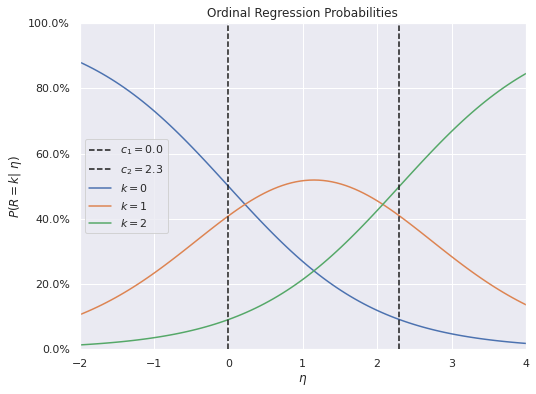

In [43]:
fig, ax = plt.subplots()

for k, c_plot in enumerate(C, start=1):
    ax.axvline(c_plot,
               c='k', ls='--', zorder=5,
               label=f"$c_{{{k}}} = {c_plot}$");

for k, p_plot_ in enumerate(p_plot.T):
    ax.plot(η_plot, p_plot_, label=f"$k = {k}$");

ax.set_xlim(-2, 4);
ax.set_xlabel(r"$\eta$");

ax.set_ylim(0, 1);
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel(r"$P(R = k \|\ \eta)$");

ax.legend();
ax.set_title("Ordinal Regression Probabilities");

Those familiar with common applications of ordinal regression and/or [psychometrics](https://en.wikipedia.org/wiki/Psychometrics) will recognize that we are quite close to having specified an ordered [item-response model](https://en.wikipedia.org/wiki/Item_response_theory).  In a typical ordinal item-response model, the cut points $c_k$ are allowed to vary according to the item being rated and the latent quantity $\eta$ is allowed to vary according to the item being rated and the person doing the rating.  Unfortunately with our Brickset data, we have no information about the individual raters so we cannot form an item-response model.  Instead, we will infer a fixed set of cutpoints and allow $\eta$ to vary based on the set being rated.

Intriguingly, Brickset also allows members to leave [reviews](https://brickset.com/reviews/year-2021) of specific sets which contain ratings along several dimensions.  I have in fact scraped this review data, but exploratory data analysis shows that very few members rate more than one set, so I am not yet confident that I can build a useful item-response model using this data.  Building such a model may be the topic of a future post, but for the moment we restrict our attention to the anonymous ratings we have explored above.,

### Time

Our first model attempts to capture the temporal dynamics of ratings based on the year in which the set was released, as shown above.

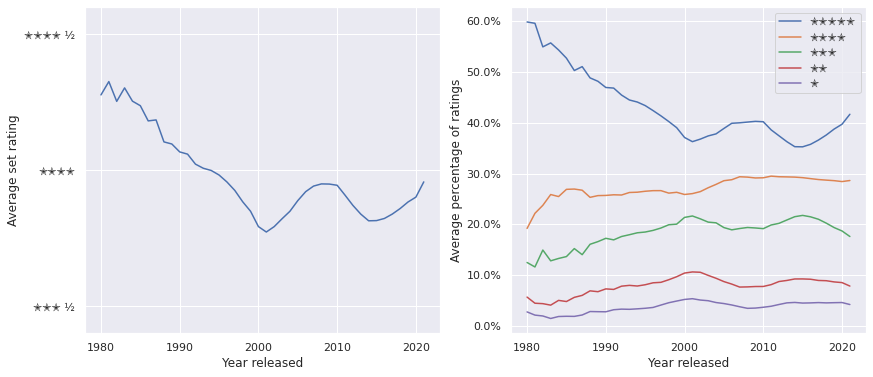

In [44]:
time_fig

This focus on time (and set) effects will allow us to start by building a somewhat simple ordinal regression model in [`pymc3`](https://docs.pymc.io/).

This model will use smoothing splines to model the effect of year on ratings and set-level random effects to capture the popularity of a set relative to the baeline popularity of all sets in the year it was released.

We now establish some notation.  Throughout, $i$ will denote the index of a set in `rated_df`.  Let $N_i$ be the number of times that set was rated and $\mathbf{R}_i = (R_{i, 1}, R_{i, 2}, R_{i, 3}, R_{i, 4}, R_{i, 5})$ be the number of one-, two-, three-, four-, and five-star ratings for the $i$-th set, respectively.

In [45]:
n_rating = len(RATING_COLS)
n_cut = n_rating - 1

ratings_ct = rated_df[RATING_COLS].values
ratings = rated_df["Ratings"].values

Let $t(i)$ be (the index of) the year that the $i$-th set was released.

In [46]:
t, year_map = rated_df["Year released"].factorize(sort=True)
n_year = year_map.size

In our first model, we have

$$\eta_i = f_{t(i)} + \beta_{\text{set}, i}.$$

Here $f_t$ is a smoothing spline meant to capture the average rating of sets released in the $t$-th year.  This post will not cover in depth the process for specifying a Bayesian smoothing spline.  Interested readers should consult a previous [post](https://austinrochford.com/posts/2021-08-11-splines-hetero.html) of mine for details.

In [47]:
N_KNOT = 10

knots = np.linspace(0, n_year, N_KNOT)
bf = sp.interpolate.BSpline(knots, np.eye(N_KNOT), 3)
t_dmat = bf(np.arange(n_year))

In [48]:
coords = {
    "cut": np.arange(n_cut),
    "rating": RATING_COLS,
    "knot": np.arange(N_KNOT),
    "set": rated_df.index.values,
    "year": year_map
}

In [49]:
SEED = 123456789 # for reproducibility

In [50]:
with pm.Model(coords=coords, rng_seeder=SEED) as model:
    β_t_inc = pm.Normal("β_t_inc", 0., 0.1, dims="knot")
    β_t = β_t_inc.cumsum()
    f_t = pm.Deterministic("f_t", at.dot(t_dmat, β_t), dims="year")

The set-level random effects $\beta_{\text{set}, i}$ follow a hierarchical normal distribution equivalent to

$$
\begin{align*}
    \sigma_{\beta_{\text{set}}}
        & \sim \text{Half}-N\left(2.5^2\right) \\
    \beta_{\text{set}, i}
        & \sim N\left(0, \sigma_{\beta_{\text{set}}}^2\right).
\end{align*}
$$

In practice, we use an equivalent [non-centered parametrization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) that samples better in practice than this more mathematically elegant one.

Note that it is important that the prior expected value of $\eta_i$ be fixed (in our case it is zero), otherwise model will not be [identified](https://en.wikipedia.org/wiki/Identifiability).  If the prior expected value is not fixed, adding any constant to the cutpoints and $\eta$ will produce the same likelihood.

In [51]:
# the scale necessary to make a halfnormal distribution
# have unit variance
HALFNORMAL_SCALE = 1. / np.sqrt(1. - 2. / np.pi)

def noncentered_normal(name, *, dims, μ=None, σ=2.5):
    if μ is None:
        μ = pm.Normal(f"μ_{name}", 0., 2.5)

    Δ = pm.Normal(f"Δ_{name}", 0., 1., dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", σ * HALFNORMAL_SCALE)

    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

In [52]:
with model:
    β_set = noncentered_normal("β_set", dims="set", μ=0.)

    η = f_t[t] + β_set

We place a $N\left(0, 2.5^2\right)$ squared prior on the cutpoints, constraining them to be ordered with the keyword argument `transform=pm.transforms.ordered`.

In [53]:
with model:
    c = pm.Normal("c", 0., 2.5, dims="cut",
                  transform=pm.transforms.ordered,
                  initval=coords["cut"])

It now remains to specify the likelihood of the observed rankings.  Since the data we have is the count of ratings for each number of stars, an ordered [multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution) model is appropriate.

In [54]:
with model:
    ratings_obs = pm.OrderedMultinomial(
        "ratings_obs", η, c, ratings,
        dims=("set", "rating"),
        observed=ratings_ct
    )

We are now ready to sample from this model's posterior distribution.

In [55]:
CORES = 3

SAMPLE_KWARGS = {
    'cores': CORES,
    'random_seed': [SEED + i for i in range(CORES)]
}

In [56]:
with model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β_t_inc, Δ_β_set, σ_β_set, c]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1242 seconds.
The number of effective samples is smaller than 10% for some parameters.


Standard sampling diagnostics show no cause for concern.

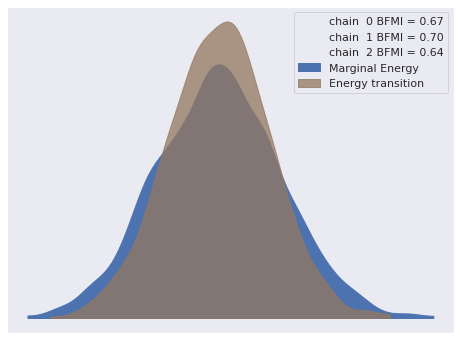

In [57]:
az.plot_energy(trace);

In [58]:
az.rhat(trace).max()

<xarray.Dataset>
Dimensions:            ()
Data variables:
    β_t_inc            float64 1.026
    Δ_β_set            float64 1.008
    σ_β_set            float64 1.012
    c                  float64 1.002
    f_t                float64 1.005
    β_set              float64 1.008
    ratings_obs_probs  float64 1.008

The following plots show that this model has captured the temporal dynamics of set ratings fairly well.

In [59]:
set_xr = (rated_df[["Year released", "Theme", "Subtheme"]]
                  .rename_axis("set")
                  .rename(columns={
                      "Year released": "year",
                      "Theme": "theme",
                      "Subtheme": "sub"
                  })
                  .to_xarray())

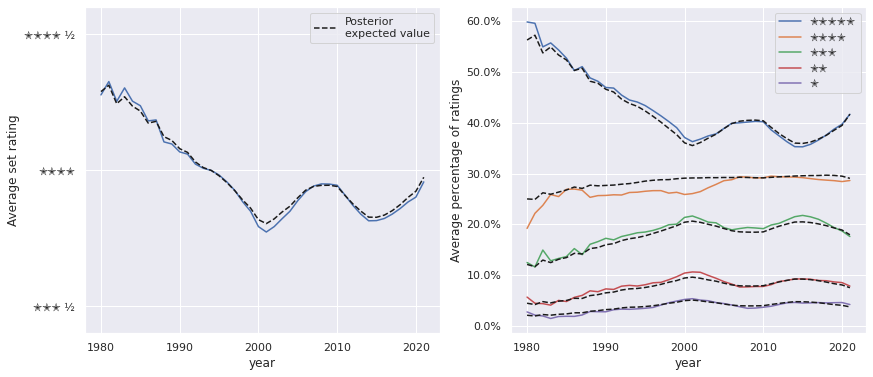

In [60]:
fig, axes = plt.subplots(
    ncols=2, sharex=True,
    figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT)
)

(rated_df["Average rating"]
         .groupby(rated_df["Year released"])
         .mean()
         .rolling(5, min_periods=1)
         .mean()
         .plot(ax=axes[0]));
(trace.posterior["ratings_obs_probs"]
      .pipe(average_rating)
      .mean(dim=("chain", "draw"))
      .groupby(set_xr["year"])
      .mean()
      .to_dataframe(name="Posterior\nexpected value")
      .rolling(5, min_periods=1)
      .mean()
      .plot(c='k', ls='--', ax=axes[0]));

axes[0].set_ylim(3.4, 4.6);
axes[0].set_yticks([3.5, 4, 4.5]);
axes[0].set_yticklabels(["✭✭✭ ½", "✭✭✭✭", "✭✭✭✭ ½"]);
axes[0].set_ylabel("Average set rating");

(rated_df[RATING_COLS]
         .div(rated_df[RATING_COLS].sum(axis=1),
              axis=0)
         .groupby(rated_df["Year released"])
         .mean()
         .rolling(5, min_periods=1)
         .mean()
         .iloc[:, ::-1]
         .plot(ax=axes[1]));
(trace.posterior["ratings_obs_probs"]
      .mean(dim=("chain", "draw"))
      .groupby(set_xr["year"])
      .mean(dim="set")
      .to_dataframe()
      .unstack(level="rating")
      ["ratings_obs_probs"]
      .rolling(5, min_periods=1)
      .mean()
      .plot(c='k', ls='--', legend=False,
            ax=axes[1]));

axes[1].yaxis.set_major_formatter(pct_formatter);
axes[1].set_ylabel("Average percentage of ratings");

We'll refine this model before we start interpreting set-level effects, but it is instructive to consider, even in this simple model, the effect of hierarchical shrinkage on sets with the fewest and the most reviews.

In [61]:
def make_row_set_label(row):
    return f"{row['Name']} ({row.name})"

def make_set_label(set_df):
    return set_df.apply(make_row_set_label, axis=1)

In [62]:
total_ratings_argsorted = ratings_ct.sum(axis=1).argsort()
fewest_total_ratings = total_ratings_argsorted[:10]
most_total_ratings = total_ratings_argsorted[-10:]

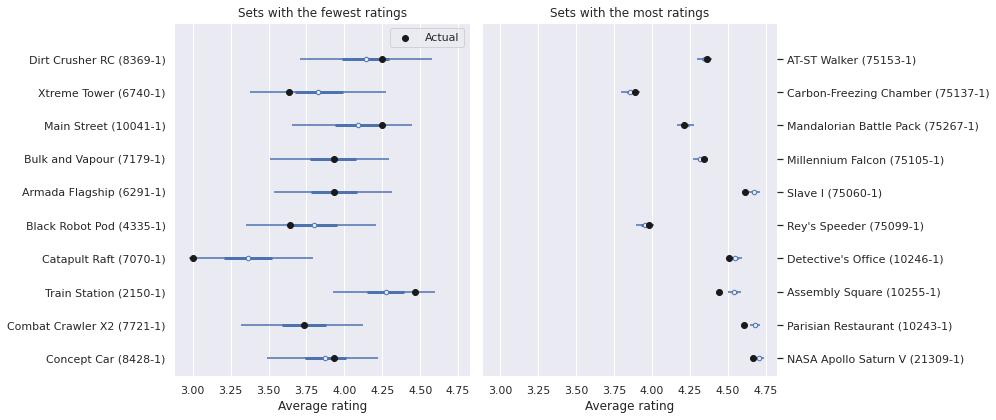

In [63]:
fig, axes = plt.subplots(
    ncols=2, sharex=True,
    figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT)
)

az.plot_forest(
    trace, var_names=["ratings_obs_probs"],
    transform=average_rating,
    coords={"set": coords["set"][fewest_total_ratings]},
    combined=True, ax=axes[0]
);
axes[0].scatter(
    rated_df["Average rating"]
            .iloc[fewest_total_ratings]
            .iloc[::-1]
            .values,
    axes[0].get_yticks(),
    c='k', zorder=5,
    label="Actual"
);

axes[0].set_xlabel("Average rating");
axes[0].set_yticklabels(make_set_label(
    rated_df.iloc[fewest_total_ratings]
            .iloc[::-1]
));

axes[0].legend();
axes[0].set_title("Sets with the fewest ratings");

az.plot_forest(
    trace, var_names=["ratings_obs_probs"],
    transform=average_rating,
    coords={"set": coords["set"][most_total_ratings]},
    combined=True, ax=axes[1]
);
axes[1].scatter(
    rated_df["Average rating"]
            .iloc[most_total_ratings]
            .iloc[::-1],
    axes[1].get_yticks(),
    c='k', zorder=5,
    label="Actual"
);

axes[1].set_xlabel("Average rating");

axes[1].yaxis.tick_right();
axes[1].set_yticklabels(make_set_label(
    rated_df.iloc[most_total_ratings]
            .iloc[::-1]
));

axes[1].set_title("Sets with the most ratings");

fig.tight_layout();

There are two interesting elements in these plots.  First is that the posterior credible intervals are much larger for the sets with the fewest ratings and for those with the most ratings.  This makes perfect sense, as we have much more information about the sets on the right.  The second is that the posterior expected ratings for the sets with the fewest ratings are significantly further from their true values than those for the sets with the most ratings.  This is reflective of the fact that our hierarcical model shrinks the observed ratings towards the average rating for the year that set was released.  This shrinkage applies more to sets with fewer reviews, resulting in the behavior show by the plot on the left.

### Full model

The full model we will use to interpret set ratings takes into account not only the year in which the set was released but also its theme and subtheme (taxonomic categories of related sets) and its piece count and price.

This model includes year- and set-effects in the same way as the previous one.

In [64]:
theme_id, theme_map = rated_df["Theme"].factorize(sort=True)

In [65]:
sub_id, sub_map = (rated_df["Subtheme"]
                           .fillna("None")
                           .factorize(sort=True))
n_sub = sub_map.size

In [66]:
coords["sub"] = sub_map
coords["theme"] = theme_map

In [67]:
with pm.Model(coords=coords, rng_seeder=SEED) as full_model:
    β_t_inc = pm.Normal("β_t_inc", 0., 0.1, dims="knot")
    β_t = β_t_inc.cumsum()
    f_t = pm.Deterministic("f_t", at.dot(t_dmat, β_t), dims="year")
    
    β_set = noncentered_normal("β_set", dims="set", μ=0.)

As shown in our exploratory data analysis, there is a fairly linear relationship between log piece count and log RRP and a set's average rating.

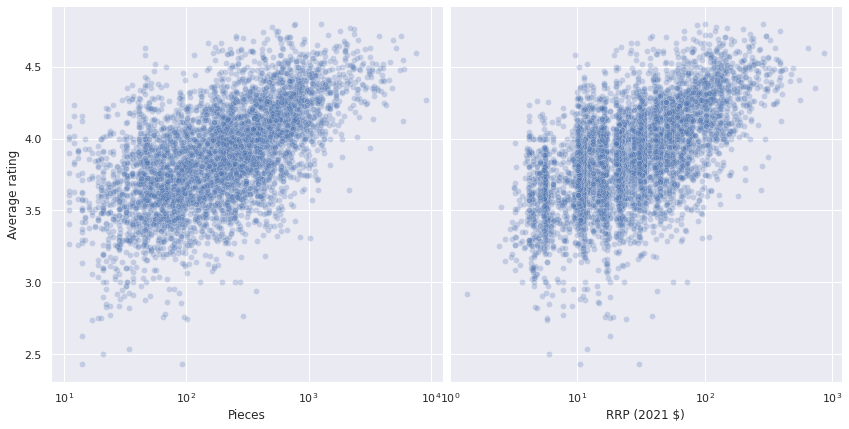

In [68]:
pieces_price_grid.fig

Incorporating log piece count and log RRP as predictors in our model is straightforward.  Let $x_{\text{pieces}, i}$ denote the standardized log piece count of the $i$-th set, and $x_{\text{price}, i}$ its standardized log RRP (in 2021 dollars).

In [69]:
def make_scaler(x):
    return StandardScaler().fit(x[:, np.newaxis])

def scale(x, scaler):
    x = np.asarray(x)

    return scaler.transform(x[:, np.newaxis])[:, 0]

In [70]:
log_pieces = np.log(rated_df["Pieces"].values)
piece_scaler = make_scaler(log_pieces)
x_pieces = scale(log_pieces, piece_scaler)

In [71]:
log_price = np.log(rated_df["RRP2021"].values)
price_scaler = make_scaler(log_price)
x_price = scale(log_price, price_scaler)

We use normal priors for the coefficients $\beta_{\text{pieces}}, \beta_{\text{price}} \sim N\left(0, 2.5^2\right)$.

In [72]:
with full_model:
    β_pieces = pm.Normal("β_pieces", 0., 2.5)
    β_price = pm.Normal("β_price", 0., 2.5)

From [one of my recent posts](https://austinrochford.com/posts/2021-07-20-ucs-gunship.html) we know that the theme and subtheme of a set have a significant impact on its price.  We therefore include these as random effects in our final model of set ratings.  

The theme of a set is the broadest taxanomic category to which the set belongs.

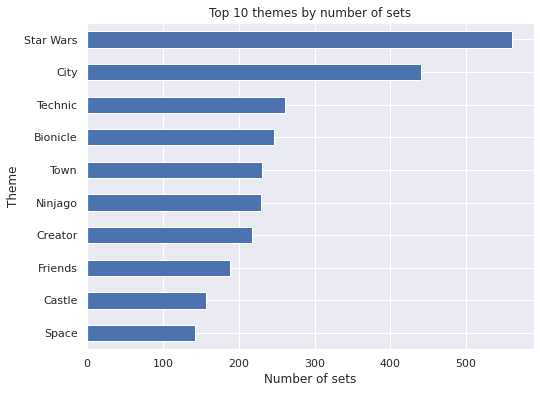

In [73]:
ax = (rated_df["Theme"]
              .value_counts()
              .nlargest(10)
              .plot.barh())

ax.set_xlabel("Number of sets");

ax.invert_yaxis();
ax.set_ylabel("Theme");

ax.set_title("Top 10 themes by number of sets");

The subtheme of a set is a finer-grained taxonomic category.

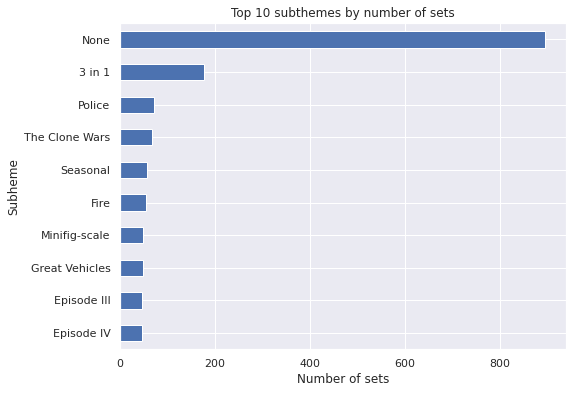

In [74]:
ax = (rated_df["Subtheme"]
              .value_counts()
              .nlargest(10)
              .plot.barh())

ax.set_xlabel("Number of sets");

ax.invert_yaxis();
ax.set_ylabel("Subheme");

ax.set_title("Top 10 subthemes by number of sets");

As an exapmle, for Star Wars-themed sets, the subtheme largely corresponds to the movie or television show to which the set is related.

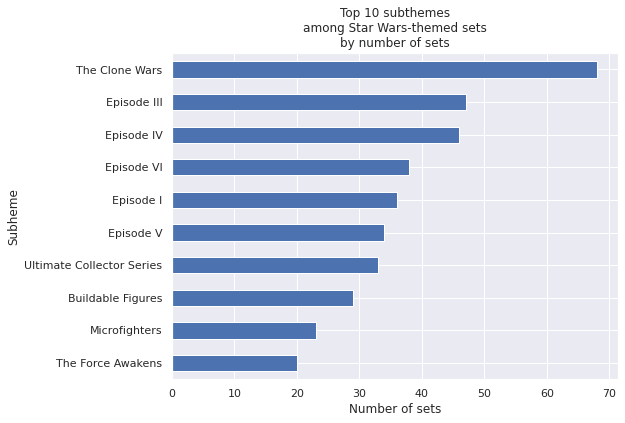

In [75]:
ax = (rated_df[rated_df["Theme"] == "Star Wars"]
              ["Subtheme"]
              .value_counts()
              .nlargest(10)
              .plot.barh())

ax.set_xlabel("Number of sets");

ax.invert_yaxis();
ax.set_ylabel("Subheme");

ax.set_title("Top 10 subthemes\namong Star Wars-themed sets\nby number of sets");

The relationship between theme and subtheme is analagous for Marvel-themed sets.

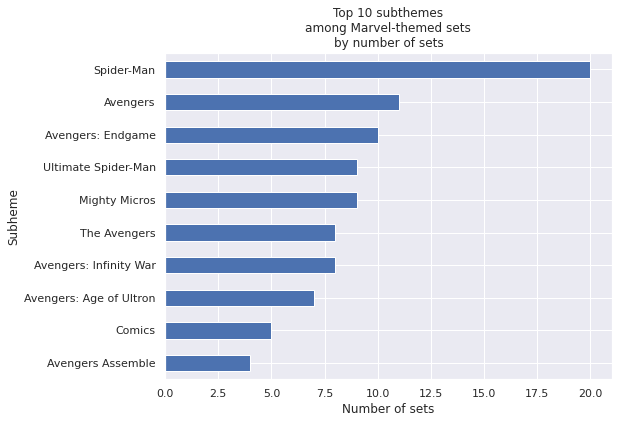

In [76]:
ax = (rated_df[rated_df["Theme"] == "Marvel Super Heroes"]
              ["Subtheme"]
              .value_counts()
              .nlargest(10)
              .plot.barh())

ax.set_xlabel("Number of sets");

ax.invert_yaxis();
ax.set_ylabel("Subheme");

ax.set_title("Top 10 subthemes\namong Marvel-themed sets\nby number of sets");

Let $j(i)$ denote the theme of the $i$-th set. The theme-level random effects use a hierarchical normal prior,

$$
\begin{align*}
    \sigma_{\beta_{\text{theme}}}
        & \sim \text{Half}-N\left(2.5^2\right) \\
    \beta_{\text{theme}, j}
        & \sim N\left(0, \sigma_{\beta_{\text{theme}}}^2\right) \\
    \gamma_{\text{theme},\ \text{pieces}}, \gamma_{\text{theme},\ \text{price}}
        & \sim N\left(0, 2.5^2\right) \\
    \beta_{\text{theme}, j}^{\text{BG}}
        & = \beta_{\text{theme}, j} + \gamma_{\text{theme},\ \text{pieces}} \cdot \bar{x}_{\text{pieces}, j} + \gamma_{\text{theme},\ \text{price}} \cdot \bar{x}_{\text{price}, j}.
\end{align*}
$$

Here $\bar{x}_{\text{pieces}, j}$ is the average standardized log number of pieces for all sets in the $j$-th theme, and $\bar{x}_{\text{price}, j}$ is the average standardized log price for those sets.  These terms are included following the guidance of [Bafumi and Gelman (2006)](http://www.stat.columbia.edu/~gelman/research/unpublished/Bafumi_Gelman_Midwest06.pdf) to account for the fact that the sets in certain themes will have more pieces/higher prices on average than other themes.  (The superscripbt ${}^{\text{BG}}$ stands for Bafumi-Gelman.)  These terms will make the theme-level random effects $\beta_{\text{theme}, j}$ more interpetable.

In [77]:
x_pieces_theme_bar = (rated_df["Pieces"]
                              .pipe(np.log)
                              .groupby(theme_id)
                              .mean()
                              .pipe(scale, piece_scaler))
x_price_theme_bar = (rated_df["RRP2021"]
                             .pipe(np.log)
                             .groupby(theme_id)
                             .mean()
                             .pipe(scale, price_scaler))

In [78]:
with full_model:
    β_theme = noncentered_normal("β_theme", dims="theme", μ=0.)
    γ_theme_pieces = pm.Normal("γ_theme_pieces", 0., 2.5)
    γ_theme_price = pm.Normal("γ_theme_price", 0., 2.5)
    β_theme_bg = pm.Deterministic(
        "β_theme_bg",
        β_theme \
            + γ_theme_pieces * x_pieces_theme_bar \
            + γ_theme_price * x_price_theme_bar,
        dims="theme"
    )

Let $\ell(i)$ denote the subtheme of the $i$-th set. The subtheme-level random effects for sets with an associated subtheme follow a similar hierarchical normal prior (with the Bafumi-Gelman terms),

$$
\begin{align*}
    \sigma_{\beta_{\text{sub}}}
        & \sim \text{Half}-N\left(2.5^2\right) \\
    \beta_{\text{sub}, \ell}
        & \sim N\left(0, \sigma_{\beta_{\text{sub}}}^2\right) \\
    \gamma_{\text{sub},\ \text{pieces}}, \gamma_{\text{sub},\ \text{price}}
        & \sim N\left(0, 2.5^2\right) \\
    \beta_{\text{sub}, \ell}^{\text{BG}}
        & = \beta_{\text{sub}, \ell} + \gamma_{\text{sub},\ \text{pieces}} \cdot \check{x}_{\text{pieces}, \ell} + \gamma_{\text{sub},\ \text{price}} \cdot \check{x}_{\text{price}, \ell}.
\end{align*}
$$

Here $\check{x}_{\text{pieces}, \ell}$ is the average standardized log number of pieces for all sets in the $\ell$-th subtheme, and $\check{x}_{\text{price}, \ell}$ is the average standardized log price for those sets.

In [79]:
x_pieces_sub_bar = (rated_df["Pieces"]
                            .pipe(np.log)
                            .groupby(sub_id)
                            .mean()
                            .pipe(scale, piece_scaler))
x_price_sub_bar = (rated_df["RRP2021"]
                           .pipe(np.log)
                           .groupby(sub_id)
                           .mean()
                           .pipe(scale, price_scaler))

In [80]:
with full_model:
    β_sub = noncentered_normal("β_sub", dims="sub", μ=0.)
    γ_sub_pieces = pm.Normal("γ_sub_pieces", 0., 2.5)
    γ_sub_price = pm.Normal("γ_sub_price", 0., 2.5)
    β_sub_bg = pm.Deterministic(
        "β_sub_bg",
        β_sub \
            + γ_sub_pieces * x_pieces_sub_bar \
            + γ_sub_price * x_price_sub_bar,
        dims="sub"
    )

We then let

$$\eta_i = f_{t(i)} + \beta_{\text{theme}, j(i)}^{\text{BG}} + \beta_{\text{sub}, \ell(i)}^{\text{BG}} + \beta_{\text{pieces}} \cdot x_{\text{pieces}, i} + \beta_{\text{price}} \cdot x_{\text{price}, i} + \beta_{\text{set}, i}.$$

In [81]:
with full_model:
    η = f_t[t] \
            + β_set + β_theme_bg[theme_id] + β_sub_bg[sub_id] \
            + β_pieces * x_pieces + β_price * x_price

With this definition of $\eta_i$, the cutpoints and likelihoods are specified similarly to the previous two models.

In [82]:
with full_model:    
    c = pm.Normal("c", 0., 2.5, dims="cut",
                  transform=pm.transforms.ordered,
                  initval=coords["cut"])
    
    ratings_obs = pm.OrderedMultinomial(
        "ratings_obs", η, c, ratings,
        dims=("set", "rating"),
        observed=ratings_ct
    )

We smple from the posterior and posterior predictive distributions of this model.

In [83]:
with full_model:
    full_trace = pm.sample(**SAMPLE_KWARGS)
    pp_trace = pm.sample_posterior_predictive(full_trace)
    
full_trace.extend(pp_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β_t_inc, Δ_β_set, σ_β_set, β_pieces, β_price, Δ_β_theme, σ_β_theme, γ_theme_pieces, γ_theme_price, Δ_β_sub, σ_β_sub, γ_sub_pieces, γ_sub_price, c]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2400 seconds.
The number of effective samples is smaller than 25% for some parameters.


Once again the sampling diagnostics show no cause for concern.

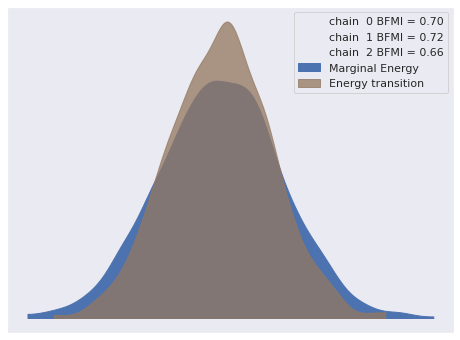

In [84]:
az.plot_energy(full_trace);

In [85]:
az.rhat(full_trace).max()

<xarray.Dataset>
Dimensions:            ()
Data variables: (12/21)
    β_t_inc            float64 1.005
    Δ_β_set            float64 1.009
    σ_β_set            float64 1.002
    β_pieces           float64 1.004
    β_price            float64 1.002
    Δ_β_theme          float64 1.007
    ...                 ...
    β_set              float64 1.01
    β_theme            float64 1.006
    β_theme_bg         float64 1.005
    β_sub              float64 1.006
    β_sub_bg           float64 1.006
    ratings_obs_probs  float64 1.01

We use [Pareto-smoothed importance sampling leave-one-out cross validation](https://arxiv.org/abs/1507.04544) (PSIS-LOO) to compare this model to the previous one.

In [86]:
traces = {
    "Time": trace,
    "Full": full_trace
}

In [87]:
%%time
comp_df = az.compare(traces)
comp_df.loc[:, :"dse"]

CPU times: user 55.2 s, sys: 5.01 ms, total: 55.2 s
Wall time: 55.2 s


,rank,loo,p_loo,d_loo,weight,se,dse
Full,0,-50609.673077,2830.614967,0.000000,0.92172,229.793944,0.000000
Time,1,-51275.468893,3515.020761,665.795816,0.07828,224.322963,38.636911


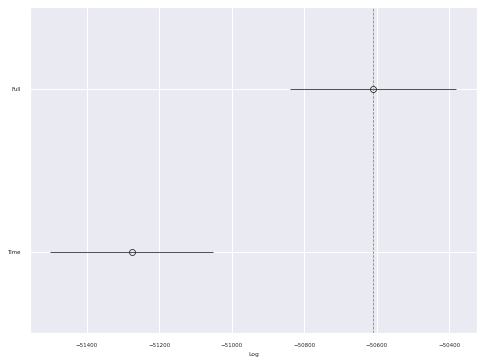

In [88]:
fig, ax = plt.subplots()

az.plot_compare(comp_df,
                plot_ic_diff=False, insample_dev=False,
                ax=ax);

It is fascinating that despite adding random effects for themes and subthemes, resulting in over 500 additional formal parameters, this final model has the fewer effective parameters by a reasonable margin.

In [89]:
sum([
    theme_map.size + 1, # one parameters per theme, plus the theme scale
    sub_map.size + 1, # one parameter per subtheme, plues the subtheme scale
    2 # regression coefficients
])

564

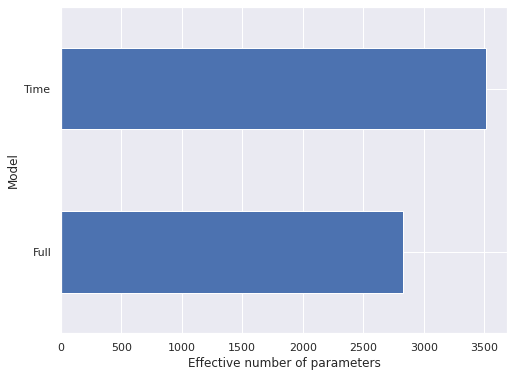

In [90]:
ax = (comp_df["p_loo"]
             .plot.barh())

ax.set_xlabel("Effective number of parameters");
ax.set_ylabel("Model");

### Analysis

First we sanity check the model's predictions by calculating the posterior predicted average rating and the associated residual.

In [91]:
pp_avg_rating = (full_trace.posterior_predictive
                           ["ratings_obs"]
                           .pipe(average_rating)
                           .mean(dim=("chain", "draw")))
rated_df["Residual average rating"] = rated_df["Average rating"] - pp_avg_rating

The following plot shows that the residuals are fairly well-centered around zero and reasonably small.

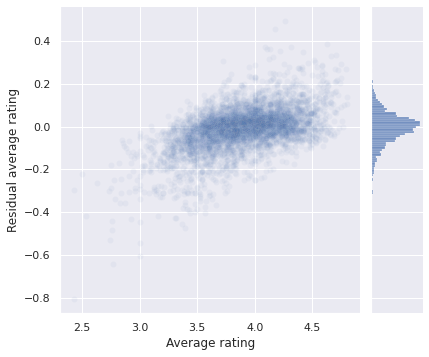

In [92]:
grid = sns.jointplot(
    x="Average rating", y="Residual average rating",
    data=rated_df,
    alpha=0.05
)

grid.ax_marg_x.set_visible(False);

We do see that our model tends to predict higher-than-observed average ratings (resulting in negative residuals) for poorly rater models and lower-than-observed average ratings (resulting in positive residuals) for highly rated models.  This behavior is due to the shrinkage caused by our hierarchical model for set-level effects.  As shown above, this model shrinks the predicted ratings of sets with relatively few ratings towards the overall average rating.

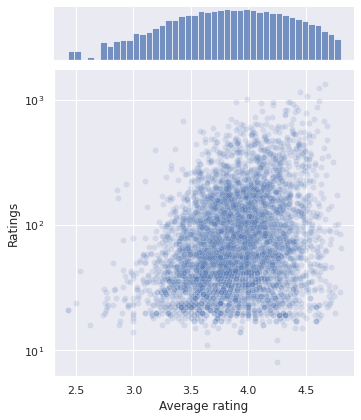

In [93]:
grid = sns.jointplot(x="Average rating", y="Ratings", data=rated_df,
                     alpha=0.15)

grid.ax_joint.set_yscale('log');
grid.ax_marg_x.set_yscale('log');
grid.ax_marg_y.set_visible(False);

We see that sets with extremely low ratings (less than roughly 3.3) or extremely high ratings (above roughly 4.6) tends to have fewer overall ratings than other sets.  The predicted ratings for these sets are therefore shrunk towards the mean, resulting in the behavior of the residuals shown above.

Plotting residuals versus our regression features (pieces and price) shows perhaps a slight negative trend, with the model systematically (slightly) overestimating the effect ratings of very large/expensive sets.

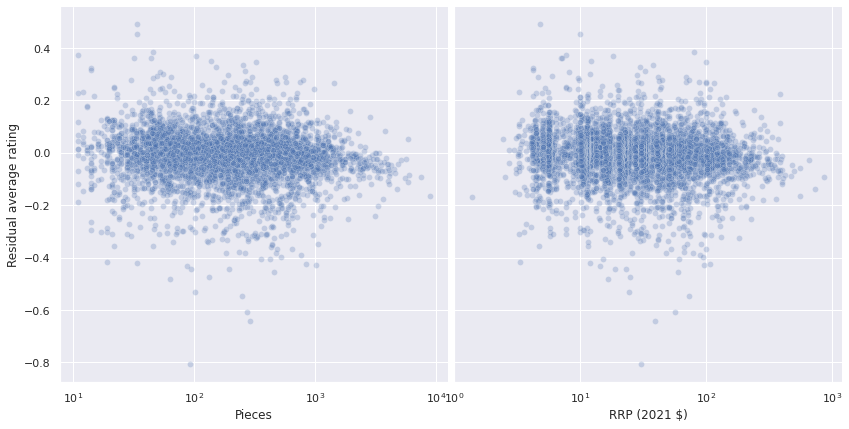

In [94]:
grid = sns.pairplot(
    rated_df,
    x_vars=["Pieces", "RRP2021"],
    y_vars=["Residual average rating"],
    plot_kws={'alpha': 0.25},
    height=FIG_HEIGHT
)

axes = grid.axes.squeeze()

axes[0].set_xscale('log');

axes[1].set_xscale('log');
axes[1].set_xlabel("RRP (2021 $)");

We could certainly improve the model by making the relationship between (log) pieces and price and ratings be nonlinear.  For simplicity we do not pursue these changes since this discussion applies to relatively few sets.  (Addressing this issue may be in interesting future post, but this one is already long enough.)

Recall that our model decomposes ratings into a sum of time, theme, subtheme, piece count, price, and set effects.  The effect of time was addressed in the first model.  We start our analysis with piece count and price effects, then proceed to analyze theme effects, subtheme effects, set effects, and the relationship between Star Wars set ratings and the reception of the related film/TV series in turn.

#### Piece count and price

Unsurprisingly the posterior distributions of the regression coefficients for (the standardized logarithm of) the set's piece count and price are positive.  It is important to recall from previous posts that piece count and price are highly correlated (of course Lego charges more for sets that have more pieces and therefore higher production cost).

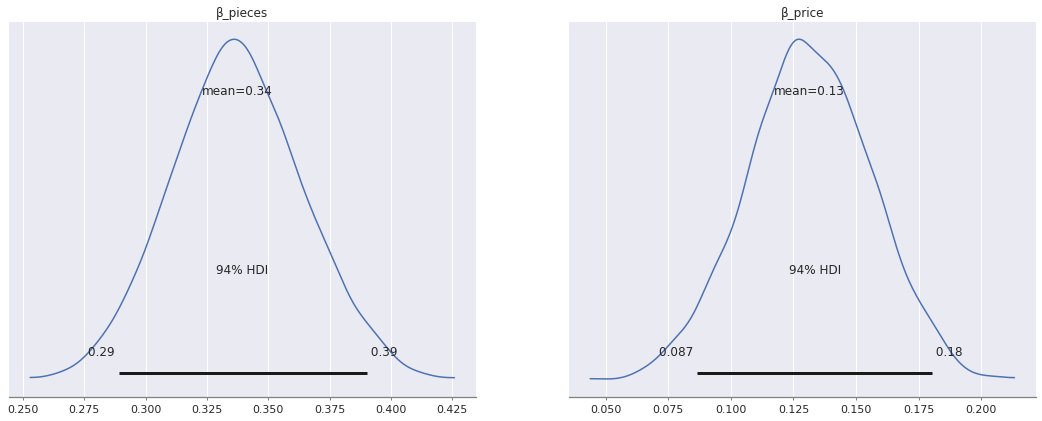

In [95]:
az.plot_posterior(full_trace, var_names=["β_pieces", "β_price"]);

It is also intuitive that these posterior distributions are concentrated above zero. Larger, more expensive sets are naturally a more considered purchase and therefore the underlying quality of the design must be higher to justify the purchase.  (We are of course assuming that most of the raters purchased the set for themselves. Outside of review sets distributed by Lego for publicity and gifted sets this assumption seems reasonable.)

We also examine the coefficients of the Bafumi-Gelman correction terms for the average (standardized logarithm of the) piece count and price for theme and subtheme effects.

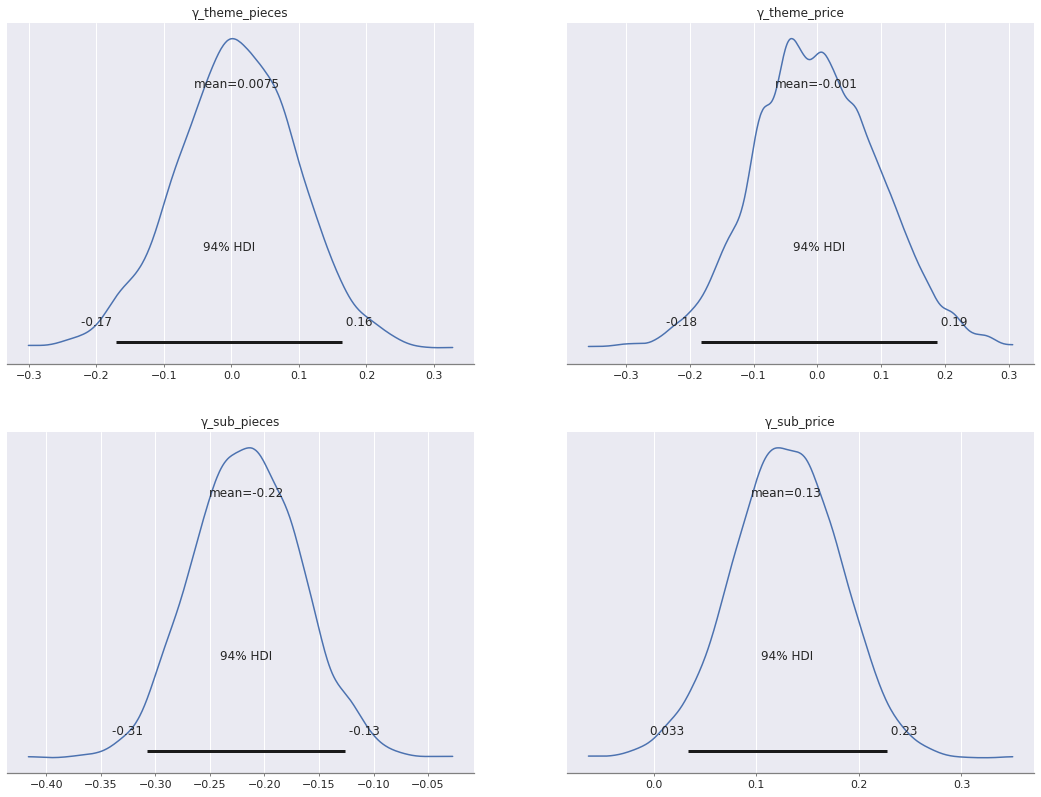

In [96]:
az.plot_posterior(full_trace, var_names="γ", filter_vars="like", grid=(2, 2));

Interestingly, the corrections for theme effects for both piece count and price are hard to distinguish from zero, while the same corrections for subtheme effects are well-separated from zero.  The sign difference is in the posterior distributions of $\gamma_{\text{sub}, \text{pieces}}$ and $\gamma_{\text{sub}, \text{price}}$ is interesting.

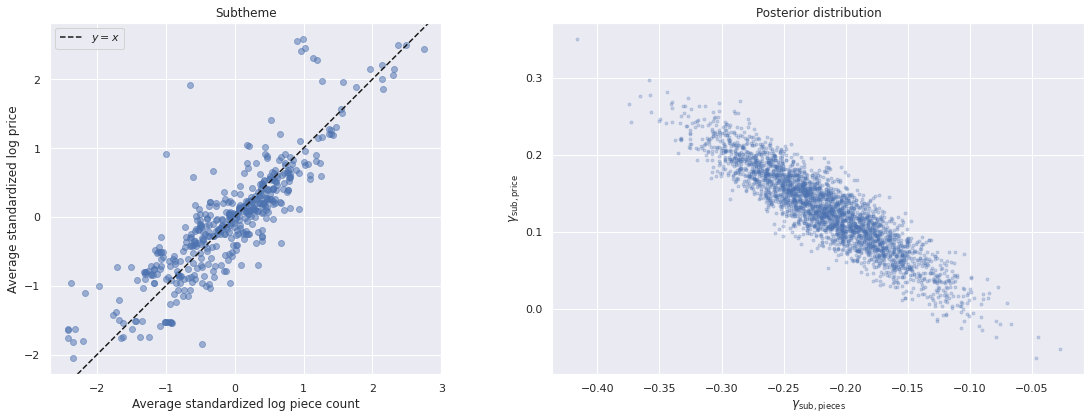

In [97]:
fig, axes = plt.subplots(ncols=2, figsize=(2 * FIG_WIDTH, FIG_HEIGHT))
axes[0].set_aspect('equal');

axes[0].scatter(x_pieces_sub_bar, x_price_sub_bar, alpha=0.5);
axes[0].axline(
    (0, 0), slope=1, ls='--', c='k',
    label="$y = x$"
);

axes[0].set_xlabel("Average standardized log piece count");
axes[0].set_ylabel("Average standardized log price");

axes[0].legend();
axes[0].set_title("Subtheme");

az.plot_pair(
    full_trace, var_names="γ_sub", filter_vars="like",
    scatter_kwargs={'alpha': 0.25},
    ax=axes[1]
);

axes[1].set_xlabel(r"$\gamma_{\mathrm{sub}, \mathrm{pieces}}$");
axes[1].set_ylabel(r"$\gamma_{\mathrm{sub}, \mathrm{price}}$");
axes[1].set_title("Posterior distribution");

fig.tight_layout();

The plot on the left shows that $\check{x}_{\text{pieces}, \ell}$ and $\check{x}_{\text{price}, \ell}$ are highly correlated (in fact they are quite close to the line $y = x$ in many cases).  Unsurprisingly, the plot on the right shows that the posterior samples for the Bafumi-Gelman correction coefficients are similarly highly correlated.

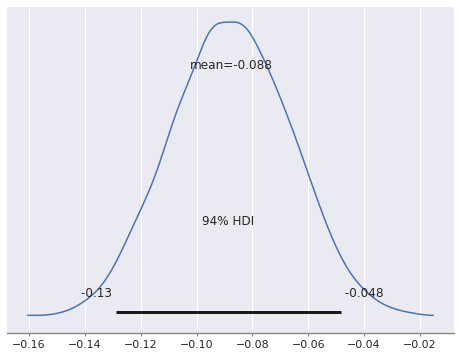

In [98]:
ax = az.plot_posterior(
    full_trace.posterior["γ_sub_pieces"] \
        + full_trace.posterior["γ_sub_price"]
)
ax.set_title(None);

This plot shows the posterior distribution of $\gamma_{\text{sub},\ \text{pieces}} + \gamma_{\text{sub},\ \text{price}}$.  This distribution together with the relationship between $\check{x}_{\text{pieces}, \ell}$ and $\check{x}_{\text{price}, \ell}$ show that as the average number of pieces in sets in a subtheme increases (and therefore their average price), the effect of subtheme on average rating is slightly negative.  Stated another way, sets from subthemes with higher average (standardized log) piece counts have to have higher piece counts to reap the benefits from $\beta_{\text{pieces}}$ and $\beta_{\text{price}}$.

#### Theme

The following plot shows the themes with the largest and smallest impact on rating as quantified by $\beta_{\text{theme}, j}$.

In [99]:
def get_extreme_coords(x, coord, n=20):
    argsorted_coord = (x.isel({coord: x.argsort().values})
                        .coords[coord]
                        .values)

    return np.concatenate((
        argsorted_coord[:n // 2], argsorted_coord[-(n // 2):]
    ))

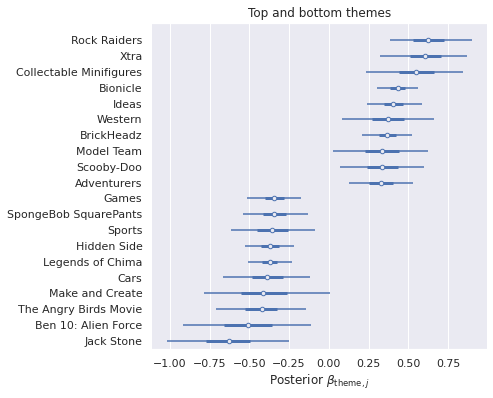

In [100]:
β_theme_post_mean = (full_trace.posterior["β_theme"]
                               .mean(dim=("chain", "draw")))

β_theme_post_mean_ext = get_extreme_coords(β_theme_post_mean, "theme")

ax, = az.plot_forest(
    full_trace, var_names=["β_theme"],
    coords={"theme": β_theme_post_mean_ext[::-1]},
    combined=True
);

ax.set_xlabel(r"Posterior $\beta_{\mathrm{theme}, j}$");
ax.set_yticklabels(β_theme_post_mean_ext);
ax.set_title("Top and bottom themes");

A few of these themes jump out at me.  It makes sense that the "Ideas" theme would have a high theme effect, because these are sets that were produced after being [proposed and voted on by Lego fans](https://ideas.lego.com/).  It seems reasonable that the sentiments of those that vote for sets on Lego Ideas and those that rate sets on Bricksets would be aligned. I also thoroughly enjoy my collection of Star Wars BrickHeadz.

<center>
    <img alt="My Star Wars BrickHeadz and MicroFighters" src="https://austinrochford.com/resources/lego/brickheadz.png" width=600>
</center>

The themes with lower effects are a bit harder to interpret; I'm not particularly familiar with any of these themes.  I do, however, not find it very hard to believe that SpongeBob SquarePants and Angry Birds Movie sets would not be particularly well-received, espescially by the sort of person that is likely to be rating sets on Brickset.  One notable trend here is that there are many child-focused themes among the themes with the most negative effects.  I would not, in general, expect children to be logging into Brickset to rate sets, so perhaps parents are more inclined to log on and rate the sets that have disappointed their children than to rate ones that satisfied them.

The Star Wars theme effect is slightly negative.  We'll analyze the factors driving the ratings of Star Wars sets in more detail shortly.

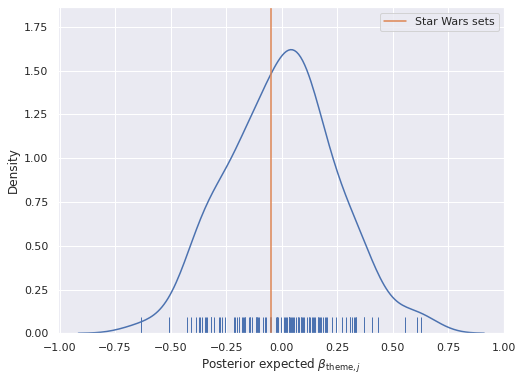

In [101]:
ax = sns.kdeplot(β_theme_post_mean)
sns.rugplot(β_theme_post_mean.to_numpy(),
            height=0.05, c='C0', ax=ax);
ax.axvline(β_theme_post_mean[theme_map == "Star Wars"],
           c='C1', label="Star Wars sets");

ax.set_xlabel(r"Posterior expected $\beta_{\mathrm{theme}, j}$");
ax.legend();

#### Subtheme effects

The following plot shows the subthemes with the largest and smallest impact on rating as quantified by $\beta_{\text{sub}, \ell}$.

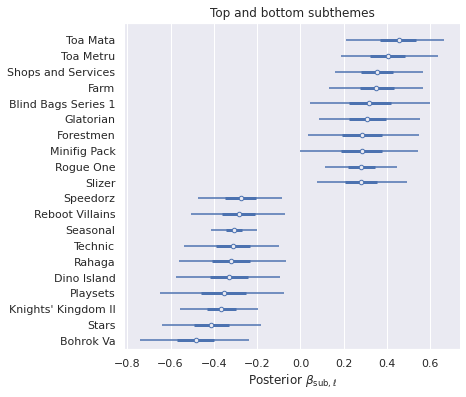

In [102]:
β_sub_post_mean = (full_trace.posterior["β_sub"]
                             .mean(dim=("chain", "draw")))

β_sub_post_mean_ext = get_extreme_coords(β_sub_post_mean, "sub")

ax, = az.plot_forest(
    full_trace, var_names=["β_sub"],
    coords={"sub": β_sub_post_mean_ext[::-1]},
    combined=True,
);

ax.set_xlabel(r"Posterior $\beta_{\mathrm{sub}, \ell}$");
ax.set_yticklabels(β_sub_post_mean_ext);
ax.set_title("Top and bottom subthemes");

I don't see much of narrative here, as I'm not familiar with many of these subthemes.  It is interesting that, out of all the Star Wars subthemes, Rogue One makes an appearance as one of the subthemes with the largest impact on ratings.

Interestingly, Star Wars subthemes as a whole don't really stand out among all subthemes.  NASA sets do, however show an above-average subtheme effect.

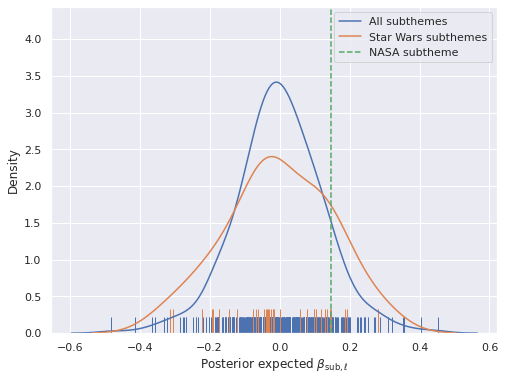

In [103]:
ax = sns.kdeplot(β_sub_post_mean.to_numpy(),
                 label="All subthemes")
sns.rugplot(β_sub_post_mean.to_numpy(),
            height=0.05, c='C0',
            ax=ax);

star_wars_subs = (rated_df[rated_df["Theme"] == "Star Wars"]
                          ["Subtheme"]
                          .unique())
sns.kdeplot(β_sub_post_mean.sel({"sub": star_wars_subs})
                           .to_numpy(),
            c='C1', label="Star Wars subthemes",
            ax=ax);
sns.rugplot(β_sub_post_mean.sel({"sub": star_wars_subs})
                           .to_numpy(),
            height=0.075, c='C1', ax=ax);

ax.axvline(β_sub_post_mean.sel({"sub": "NASA"}),
           c='C2', ls='--', label="NASA subtheme");

ax.set_xlabel(r"Posterior expected $\beta_{\mathrm{sub}, \ell}$");
ax.legend();

Returning to Rogue One, there are relatively few sets in this subtheme, and I don't own any of them.

In [104]:
rated_df[rated_df["Subtheme"] == "Rogue One"]

,Name,Set type,Year released,Theme,Subtheme,Pieces,RRP$,RRP2021,✭,✭✭,✭✭✭,✭✭✭✭,✭✭✭✭✭,Austin owns,Ratings,Average rating,Residual average rating
Set number,,,,,,,,,,,,,,,,,
75152-1,Imperial Assault Hovertank,Normal,2016,Star Wars,Rogue One,385.0,29.99,33.112344,15.0,32.0,93.0,249.0,319.0,False,708.0,4.165254,0.029373
75153-1,AT-ST Walker,Normal,2016,Star Wars,Rogue One,449.0,39.99,44.153473,20.0,34.0,74.0,278.0,546.0,False,952.0,4.361345,0.014891
75154-1,TIE Striker,Normal,2016,Star Wars,Rogue One,543.0,69.99,77.276858,5.0,20.0,76.0,196.0,262.0,False,559.0,4.234347,0.048867
75155-1,Rebel U-wing Fighter,Normal,2016,Star Wars,Rogue One,659.0,79.99,88.317987,20.0,25.0,68.0,238.0,420.0,False,771.0,4.313878,0.011525
75156-1,Krennic's Imperial Shuttle,Normal,2016,Star Wars,Rogue One,863.0,89.99,99.359115,15.0,29.0,59.0,168.0,434.0,False,705.0,4.385816,-0.013055
30496-1,U-Wing Fighter,Normal,2017,Star Wars,Rogue One,55.0,3.99,4.297959,12.0,22.0,59.0,53.0,58.0,False,204.0,3.602941,-0.003324
75164-1,Rebel Trooper Battle Pack,Normal,2017,Star Wars,Rogue One,120.0,14.99,16.146971,14.0,34.0,87.0,150.0,228.0,False,513.0,4.060429,0.007587
75165-1,Imperial Trooper Battle Pack,Normal,2017,Star Wars,Rogue One,112.0,14.99,16.146971,19.0,36.0,106.0,191.0,283.0,False,635.0,4.075591,0.009082
75171-1,Battle on Scarif,Normal,2017,Star Wars,Rogue One,419.0,49.99,53.848369,7.0,26.0,70.0,157.0,121.0,False,381.0,3.942257,0.025589


In [105]:
((rated_df["Subtheme"] == "Rogue One") & rated_df["Austin owns"]).sum()

0

I had expected [Darth Vader's Castle (75251)](https://www.lego.com/en-us/product/darth-vader-s-castle-75251) to be a Rogue One set (to my knowledge this is the movie in which the castle first appeared).  It was a build that I particularly enjoyed, but it is filed under the Miscellaneous subtheme for reasons not entirely clear to me.

In [106]:
rated_df.loc["75251-1", :"RRP2021"]

Name             Darth Vader's Castle
Set type                       Normal
Year released                    2019
Theme                       Star Wars
Subtheme                Miscellaneous
Pieces                         1060.0
RRP$                           129.99
RRP2021                      135.0871
Name: 75251-1, dtype: object

<center>
    <img src='https://c.tenor.com/mPYdNwJfu54AAAAC/darth-vader-choke-aspirations.gif'>
    <figure>
        <img src='https://austinrochford.com/resources/lego/vader_castle.png' width=600>
        <br>
        <caption>The Darth Vader exhibit in my collection</caption>
    </figure>
</center>

We'll return to Star Wars subtheme effects and how they are related to the (critical and public) reception of various entries in the Star Wars media franchise shortly.

#### Set-level

The following plot shows the sets with the largest and smallest impact on rating as quantified by $\beta_{\text{set}, i}$.

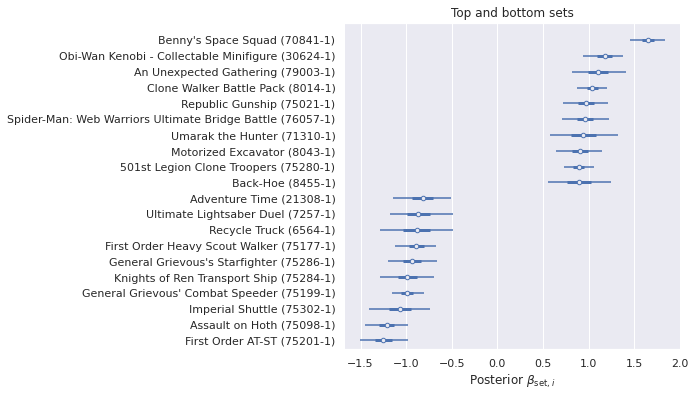

In [107]:
β_set_post_mean = (full_trace.posterior["β_set"]
                             .mean(dim=("chain", "draw")))
β_set_post_mean_ext = get_extreme_coords(β_set_post_mean, "set")

ax, = az.plot_forest(
    full_trace, var_names=["β_set"],
    coords={"set": β_set_post_mean_ext[::-1]},
    combined=True,
);

ax.set_xlabel(r"Posterior $\beta_{\mathrm{set}, i}$");
ax.set_yticklabels(make_set_label(rated_df.loc[β_set_post_mean_ext]));
ax.set_title("Top and bottom sets");

Here we finally see many Star Wars sets emerge, which makes sense.  Since the Star Wars theme effect is close to average (zero) and the distribution of Star Wars subtheme effects does not stand out from the overall distribution of subtheme effects, the set effect is left to account for Star Wars sets with particularly high or low observed ratings (after adjusting for piece count and price).  I am particularly glad to see the [501st Legion Clone Troopers (75280)](https://www.lego.com/en-us/product/501st-legion-clone-troopers-75280) listed in the top ten for set effects; it's a thoroughly enjoyable small set.  The Star Wars sets in the bottom ten for set effects suggest a trend that we will elaborate on shortly. Outside of the [Imperial Shuttle (76302)](https://www.lego.com/en-us/product/imperial-shuttle-75302) and [Assault on Hoth (75098)](https://www.lego.com/en-us/product/assault-on-hoth-75098) these sets are generally associated with the Prequel Trilogy (Episodes I, II, and III) or the Sequel Trilogy (Episodes VII, VII, and IX).  These entries in the Star Wars media franchise are (on average) less popular than the Original Trilogy (Episodes IV, V, and VI).

I am personally not terribly surprised by most of these sets with extreme negative effects.  The prevalence of First Order sets here is telling; I have found very few First Order sets compelling enough to purchase ([Kylo Ren's Shuttle (75264)](https://www.lego.com/en-us/product/kylo-ren-s-shuttle-microfighter-75264) and [First Order Heavy Assault Walker (30497)](https://brickset.com/sets/30497-1/First-Order-Heavy-Assault-Walker) notwithstanding; I am a sucker for MicroFighters and small sets in general).  I am somewhat surprised to see Imperial Shuttle (76302) on this list.  I didn't think this set was amazing, but it was not particularly bad either.  Having missed out on [Imperial Shuttle Tydirium (75094)](https://www.lego.com/en-us/product/imperial-shuttle-tydirium-75094) I consider this replacement a solid addition to my collection.

#### Rating components

With a bit of work we can visualize the cumulative influence of each component in our ratings model (year released, theme, subtheme, piece count, price, and set) on a set's overall rating.

In [108]:
def get_set_η_comp(trace, set_data):
    η_comp = (trace.posterior[["f_t", "β_theme_bg", "β_sub_bg"]]
                   .sel(set_data[["year", "theme", "sub"]]))
    η_comp["pieces"] = trace.posterior["β_pieces"] * set_data["x_pieces"]
    η_comp["price"] = trace.posterior["β_price"] * set_data["x_price"]
    η_comp["β_set"] = trace.posterior["β_set"].sel({"set": set_data["set"]})
    
    return η_comp

In [109]:
def get_comp_cumsum(η_comp):
    return (η_comp.to_array(dim="comp")
                  .cumsum(dim="comp")
                  .to_dataset("comp"))

In [110]:
def get_cum_prob(trace, set_data):
    η_comp = get_set_η_comp(trace, set_data)
    cum_η_comp = get_comp_cumsum(η_comp)
    cum_cdf_comp = ((cum_η_comp - trace.posterior["c"])
                    .pipe(sp.special.expit))
    
    cum_fst_prob = 1. - (
        cum_cdf_comp.sel(cut=0)
                    .assign(rating=xr.DataArray(["✭"], {"cut": [0]}))
                    .set_index(cut="rating")
                    .rename(cut="rating")
    )
    cum_mid_prob = -1. * (
        cum_cdf_comp.diff(dim="cut")
                    .assign(rating=xr.DataArray(["✭✭", "✭✭✭", "✭✭✭✭"],
                            {"cut": coords["cut"][1:]}))
                    .set_index(cut="rating")
                    .rename(cut="rating")
    )
    cum_last_prob = (
        cum_cdf_comp.isel(cut=-1)
                    .assign(rating=xr.DataArray(["✭✭✭✭✭"], {"cut": [3]}))
                    .set_index(cut="rating")
                    .rename(cut="rating")
    )
    
    return xr.concat(
        (cum_fst_prob, cum_mid_prob, cum_last_prob),
        dim="rating"
    )

In [111]:
def star_formatter(stars, _):
    full_stars = int(stars)
    label = full_stars * "✭"
    
    if stars != full_stars:
        label += " ½"
    
    return label

def plot_cum_avg_rating(trace, set_data, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    cum_prob = get_cum_prob(trace, set_data)
    
    az.plot_forest(
        cum_prob.pipe(average_rating),
        combined=True, hdi_prob=1.,
        kind='ridgeplot', ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.5],
        ridgeplot_alpha=0.5, ridgeplot_overlap=3.,
        ax=ax
    )
    
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(min(x_min, 3.5), max(x_max, 4.5))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_major_formatter(star_formatter)
    ax.set_xlabel("Posterior average set rating")

    ax.set_yticklabels([
        "Set",
        f"Price\n${rated_df['RRP2021'].loc[set_data['set'].values]:,.2f}",
        f"Pieces\n{rated_df['Pieces'].loc[set_data['set'].values]:,.0f}",
        f"Subtheme (BG)\n({set_data['sub'].values})",
        f"Theme (BG)\n({set_data['theme'].values})",
        f"Year released\n({set_data['year'].values})"
    ]);
    ax.set_ylabel("After cumulative effects of\n"
                  + r"$\longleftarrow$");
    
    ax.set_title(
        make_row_set_label(rated_df.loc[set_data["set"].values])
    );
    
    return ax

In [112]:
set_xr["x_pieces"] = xr.DataArray(x_pieces, {"set": rated_df.index.values})
set_xr["x_price"] = xr.DataArray(x_price, {"set": rated_df.index.values})

These plots take a bit of explanation to interpret, so we begin by considering one of the most iconic Star Wars sets of all time (it's at the top of my wish list), the [Millenium Falcon (75192)](https://www.lego.com/en-us/product/millennium-falcon-75192).

In [113]:
UCS_FALCON = "75192-1"

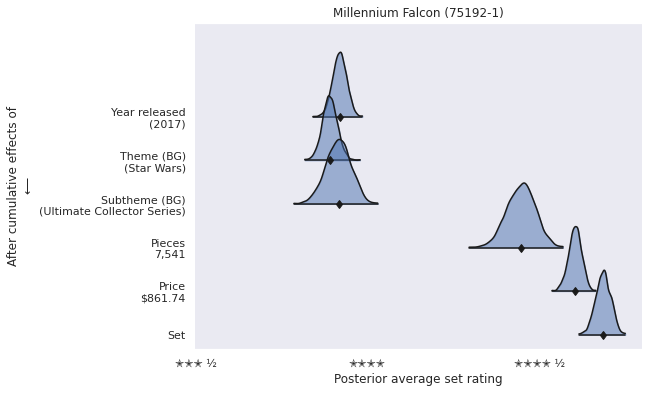

In [114]:
plot_cum_avg_rating(full_trace, set_xr.sel(set=UCS_FALCON));

This plot is best read top to bottom.  The topmost distribution is the posterior distribution of the average rating of a set released in 2017 that is average in all other respects.  The second distribution is the posterior distribution of the average rating of a Star Wars set released in 2017 that is average in all other respects, and so on.  (Note that the ordering here has been chosen for conceptual, not mathematical reasons as there is no ordering inherent in our decomposition.  In future work we may use some tools from causal inference to induce such a mathematical ordering.)

This plot shows that 75192 gets its most significant ratings boost due to the extremely large number of pieces, but the price and set effects are not to be ignored.  In short, this is an outstanding set in almost every respect.

The following plots show the ratings decomposition for three of my favorite non-Star Wars sets, [NASA Apollo Saturn V (92176)](https://www.lego.com/en-us/product/lego-nasa-apollo-saturn-v-92176), [NASA Apollo 11 Lunar Lander](https://www.lego.com/en-us/product/nasa-apollo-11-lunar-lander-10266), and [NASA Space Shuttle Discovery (10283)](https://www.lego.com/en-us/product/nasa-space-shuttle-discovery-10283).

In [115]:
SATURN_V = "92176-1"
LUNAR_LANDER = "10266-1"
SPACE_SHUTTLE = "10283-1"

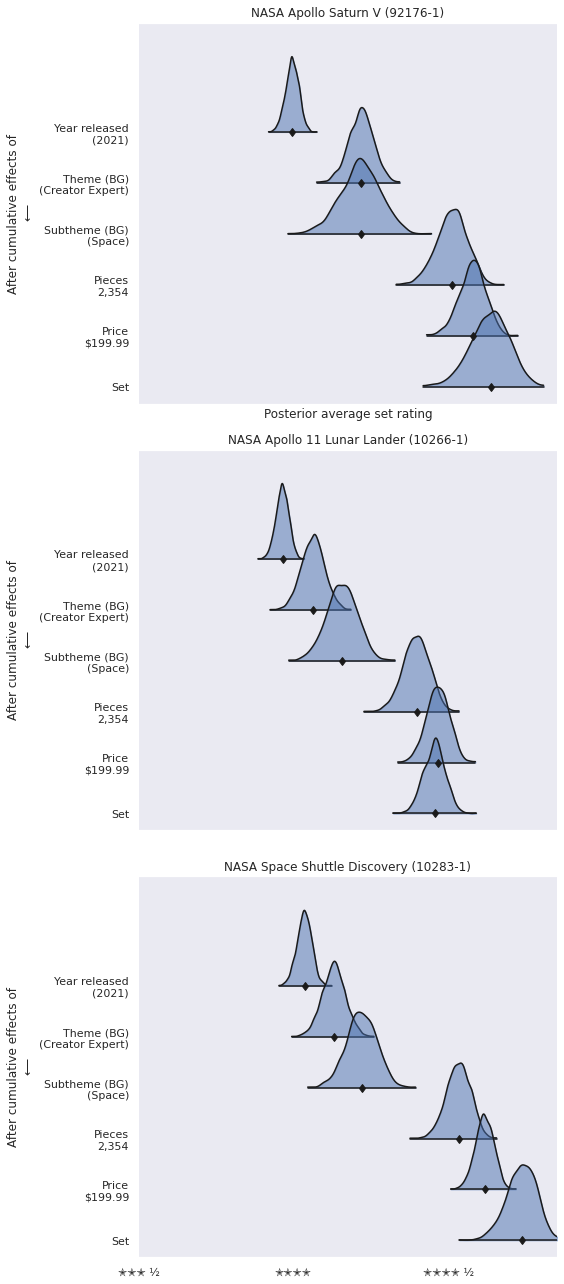

In [116]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True,
                         figsize=(FIG_WIDTH, 3 * FIG_HEIGHT))

plot_cum_avg_rating(full_trace, set_xr.sel(set=SATURN_V),
                    ax=axes[0]);
plot_cum_avg_rating(full_trace, set_xr.sel(set=LUNAR_LANDER),
                    ax=axes[1]);
plot_cum_avg_rating(full_trace, set_xr.sel(set=SPACE_SHUTTLE),
                    ax=axes[2]);

axes[1].set_xlabel(None);
axes[2].set_xlabel(None);

fig.tight_layout();

These sets get health ratings boosts from almost every factor, in contrast to most Star Wars sets.

It is interesting to contrast these decompositions with that for another one of my favorite NASA/space sets, [Women of NASA (21312)](https://www.lego.com/en-us/product/women-of-nasa-21312).

In [117]:
WOMEN_OF_NASA = "21312-1"

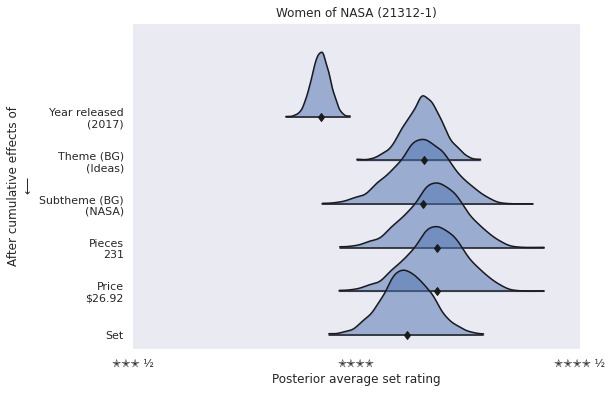

In [118]:
plot_cum_avg_rating(full_trace, set_xr.sel(set=WOMEN_OF_NASA));

This set gets its most significant boost from the Ideas theme and its small size and modest price don't contribute much.  I am a bit disappointed to see the set effect be slightly negative here.

So far we have focused on sets with average-to-high ratings.  We return to the Imperial Shuttle (75302) as an example of a set with below average ratings.

In [119]:
IMPERIAL_SHUTTLE = "75302-1"

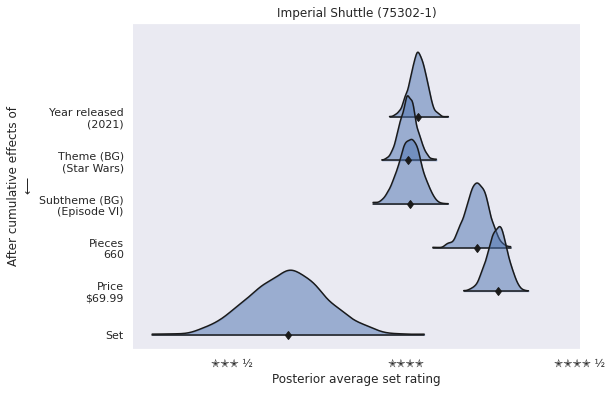

In [120]:
plot_cum_avg_rating(full_trace, set_xr.sel(set=IMPERIAL_SHUTTLE));

We see that most factors (year released, theme, subtheme, piece count, and price) point to an average (or slightly above) rating.  The final posterior average rating drops dramatically when set effects are factored in, showing that this set is well below the quality that Bricket's raters expected given its other attributes.  It is also interesting to see that the uncertainty in the posterior distribution is much larger after the set effect is included than before.

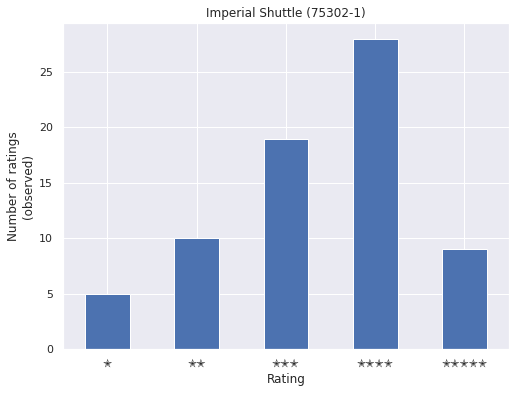

In [121]:
ax = (rated_df[RATING_COLS]
              .loc[IMPERIAL_SHUTTLE]
              .plot.bar(rot=0))

ax.set_xlabel("Rating");
ax.set_ylabel("Number of ratings\n(observed)");
ax.set_title(make_row_set_label(rated_df.loc[IMPERIAL_SHUTTLE]));

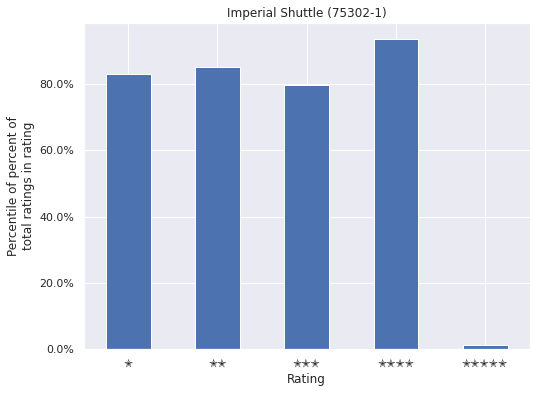

In [122]:
rating_pct = (rated_df[RATING_COLS]
                      .div(rated_df["Ratings"], axis=0))

ax = (rating_pct.le(rating_pct.loc[IMPERIAL_SHUTTLE])
                .mean()
                .plot.bar(rot=0))

ax.set_xlabel("Rating");

ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Percentile of percent of\ntotal ratings in rating");

ax.set_title(make_row_set_label(rated_df.loc[IMPERIAL_SHUTTLE]));

We see that this set has a disproportionate amount of ratings in the one to four star range and very few in the five star range (relative to all sets).  This relatively large amount of small ratings is partially responsible for the width of the final posterior once set effects have been included.

An interesting case to conisder is the [International Space Station (21321)](https://www.lego.com/en-us/product/international-space-station-21321).

In [123]:
ISS = "21321-1"

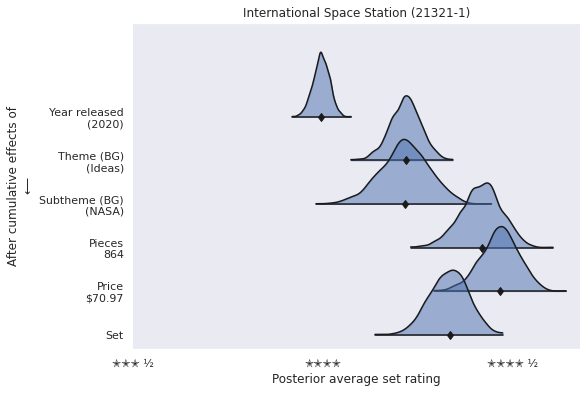

In [124]:
plot_cum_avg_rating(full_trace, set_xr.sel(set=ISS));

This set gets a boost from its theme (Ideas) and number of pieces, but the set effect reduces the overall posterior average rating appreciably.  This decomposition is in line with my experience with this set.  It is an interesting idea, but the full build is quite flimsy and prone to breaking (mine has fallen apart in various ways a few times).  Of all my NASA/space sets it is my least favorite.

For fun, we look at the decomposition of the set with the smallest posterior expected average rating.

In [125]:
WORST_SET_DATA = set_xr.isel(set=pp_avg_rating.argmin())

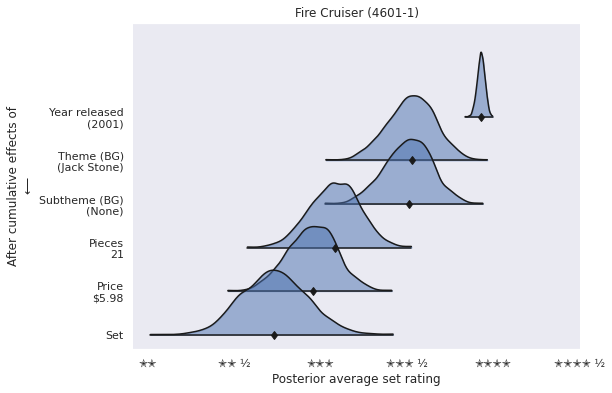

In [126]:
plot_cum_avg_rating(full_trace, WORST_SET_DATA);

This set has the deck stacked against it ratings-wise: it's from a poorly rated theme and it's small and cheap.

These decompositions are really fascinating to get lost in.  For any interested readers, I have posted the decomposition plots for every set in the data set [here](https://austinrochford.com/resources/lego/set_decomp_20211025.tar.gz) (warning: this is a 109MB gzipped tarball).

##### My collection

As in previous posts, we can use this model to shed light on my collecting behavior.

In [127]:
austin_themes = (rated_df[rated_df["Austin owns"]]
                         ["Theme"]
                         .unique())
austin_subs = (rated_df[rated_df["Austin owns"]]
                       ["Subtheme"]
                       .dropna()
                       .unique())

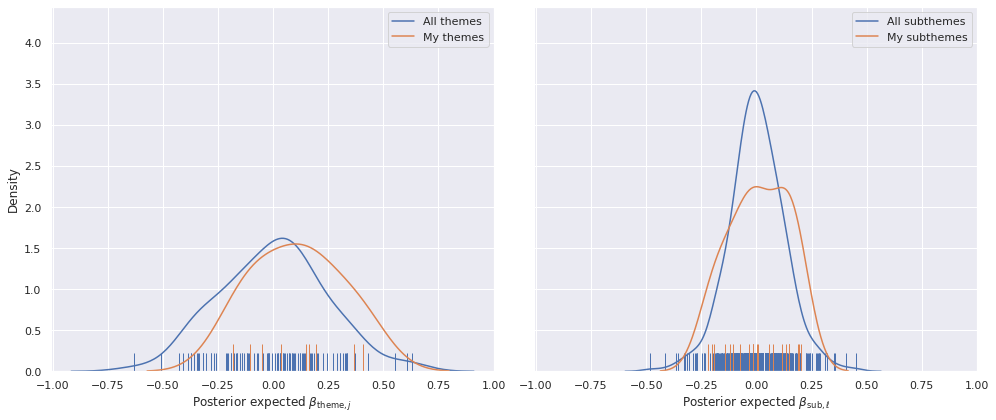

In [128]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT))

sns.kdeplot(β_theme_post_mean.to_numpy(),
            label="All themes", ax=axes[0]);
sns.rugplot(β_theme_post_mean.to_numpy(),
            height=0.05, c='C0', ax=axes[0]);

sns.kdeplot(β_theme_post_mean.sel({"theme": austin_themes})
                             .to_numpy(),
            c='C1', label="My themes", ax=axes[0]);
sns.rugplot(β_theme_post_mean.sel({"theme": austin_themes})
                             .to_numpy(),
            height=0.075, c='C1', ax=axes[0]);

axes[0].set_xlabel(r"Posterior expected $\beta_{\mathrm{theme}, j}$");
axes[0].legend();

sns.kdeplot(β_sub_post_mean.to_numpy(),
            label="All subthemes", ax=axes[1]);
sns.rugplot(β_sub_post_mean.to_numpy(),
            height=0.05, c='C0', ax=axes[1]);

sns.kdeplot(β_sub_post_mean.sel({"sub": austin_subs})
                           .to_numpy(),
            c='C1', label="My subthemes",
            ax=axes[1]);
sns.rugplot(β_sub_post_mean.sel({"sub": austin_subs})
                           .to_numpy(),
            height=0.075, c='C1', ax=axes[1]);

axes[1].set_xlabel(r"Posterior expected $\beta_{\mathrm{sub}, \ell}$");
axes[1].legend();

fig.tight_layout();

From these plots, it appears that I do tend to collect sets from themes and subthemes that tend to be (slightly) more highly reviewed than average.

The following plots show the specific posterior distributions for the themes and subthemes that of which I own at least one set.

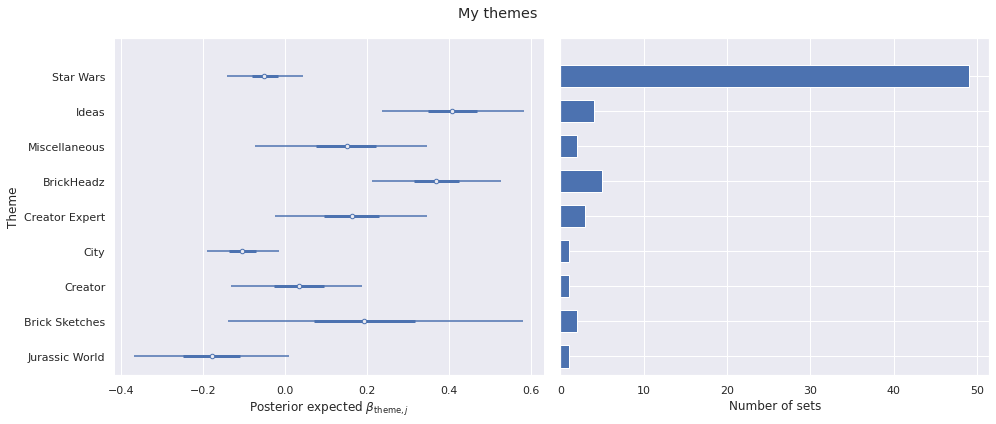

In [129]:
fig, axes = plt.subplots(ncols=2, sharey=True,
                         figsize=(1.75 * FIG_WIDTH, FIG_HEIGHT))

az.plot_forest(
    full_trace, var_names=["β_theme"],
    coords={"theme": austin_themes},
    combined=True, ax=axes[0]
);

axes[0].set_xlabel(r"Posterior expected $\beta_{\mathrm{theme}, j}$");

axes[0].set_yticklabels(austin_themes[::-1]);
axes[0].set_ylabel("Theme");

axes[0].set_title(None);

axes[1].barh(
    axes[0].get_yticks(),
    rated_df[rated_df["Austin owns"]]
            ["Theme"]
            .value_counts()
            .loc[austin_themes[::-1]]
);

axes[1].set_xlabel("Number of sets");

fig.suptitle("My themes");
fig.tight_layout();

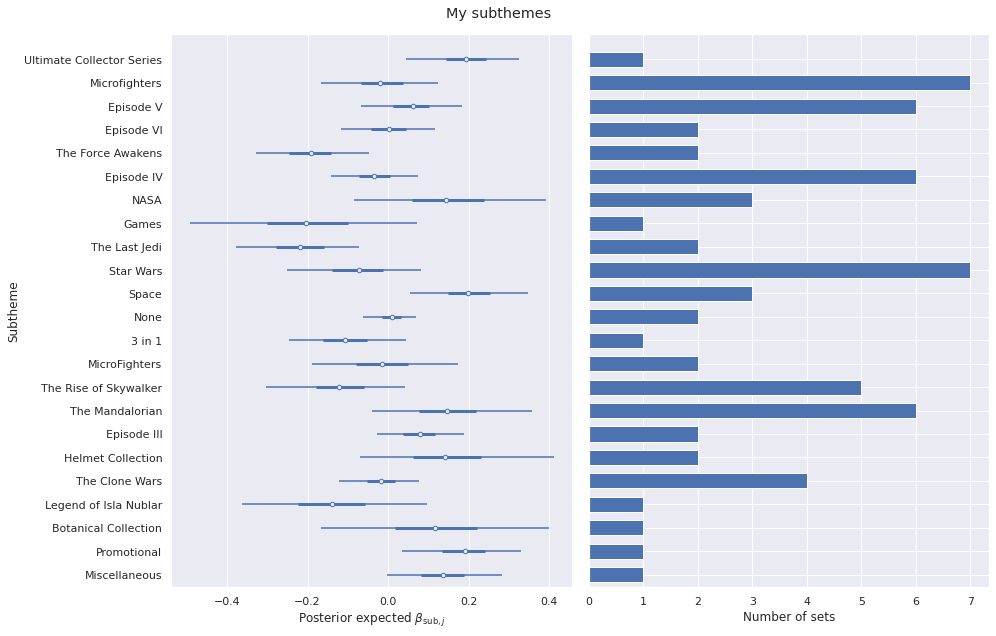

In [130]:
fig, axes = plt.subplots(ncols=2, sharey=True,
                         figsize=(1.75 * FIG_WIDTH, 1.5 * FIG_HEIGHT))


az.plot_forest(
    full_trace, var_names=["β_sub"],
    coords={"sub": austin_subs},
    combined=True, ax=axes[0]
);

axes[0].set_xlabel(r"Posterior expected $\beta_{\mathrm{sub}, j}$");

axes[0].set_yticklabels(austin_subs[::-1]);
axes[0].set_ylabel("Subtheme");

axes[0].set_title(None);

axes[1].barh(
    axes[0].get_yticks(),
    rated_df[rated_df["Austin owns"]]
            ["Subtheme"]
            .value_counts()
            .loc[austin_subs[::-1]]
);

axes[1].set_xlabel("Number of sets");

fig.suptitle("My subthemes");
fig.tight_layout();

These results would seem to justify a moderate amount of pride in my collecting habits.

#### Star Wars set ratings vs. media reception

We finally turn to our final question, whether the ratings of Star Wars sets are related to the critical and/or public reception of the entries in the Star Wars media franchise they are drawn from.

These critic and audience scores were retrieved from [Rotten Tomatoes](https://www.rottentomatoes.com/) on October 24, 2021.  There are many sources for film rating data online that could be used for this analysis, Rotten Tomatoes was chosen primarily for convenience.

In [131]:
movie_df = pd.DataFrame.from_records(
    [("Episode I", 0.52, 0.59),
     ("Episode II", 0.65, 0.56),
     ("Episode III", 0.8, 0.66),
     ("Episode IV", 0.92, 0.96),
     ("Episode V", 0.94, 0.97),
     ("Episode VI", 0.82, 0.95),
     ("The Force Awakens", 0.93, 0.85),
     ("Rogue One", 0.84, 0.86),
     ("The Last Jedi", 0.91, 0.42),
     ("Solo", 0.7, 0.64),
     ("The Rise of Skywalker", 0.52, 0.86)],
    columns=["Subtheme", "Critics", "Audiences"]
)

movie_df["post_mean"] = β_sub_post_mean.sel(sub=movie_df["Subtheme"].values)
movie_df["bg_post_mean"] = (full_trace.posterior["β_sub_bg"]
                                      .sel(sub=movie_df["Subtheme"].values)
                                      .mean(dim=("chain", "draw")))

movie_df["Critics (logit)"] = sp.special.logit(movie_df["Critics"])
movie_df["Audiences (logit)"] = sp.special.logit(movie_df["Audiences"])

In [132]:
movie_df

,Subtheme,Critics,Audiences,post_mean,bg_post_mean,Critics (logit),Audiences (logit)
0,Episode I,0.52,0.59,-0.172209,-0.185344,0.080043,0.363965
1,Episode II,0.65,0.56,0.104313,0.075953,0.619039,0.241162
2,Episode III,0.80,0.66,0.077215,0.047762,1.386294,0.663294
3,Episode IV,0.92,0.96,-0.034464,-0.059945,2.442347,3.178054
4,Episode V,0.94,0.97,0.057337,0.015157,2.751535,3.476099
5,Episode VI,0.82,0.95,0.000920,0.006223,1.516347,2.944439
6,The Force Awakens,0.93,0.85,-0.194143,-0.238966,2.586689,1.734601
7,Rogue One,0.84,0.86,0.281671,0.218561,1.658228,1.815290
8,The Last Jedi,0.91,0.42,-0.220747,-0.300822,2.313635,-0.322773
9,Solo,0.70,0.64,-0.029700,-0.108130,0.847298,0.575364


Here we have both the raw and log-odds transformed critics and audiences scores from Rotten Tomatoes along with the posterior expected values of both subtheme effects, $\beta_{\text{sub}, j}$ and $\beta_{\text{sub}, j}^{\text{BG}}$.

In [133]:
REVIEW_SCORES = ["Critics", "Audiences", "Critics (logit)", "Audiences (logit)"]
POST_EFFECTS = ["post_mean", "bg_post_mean"]

In [134]:
def add_corr(x, y, **_):
    ax = plt.gca()
    
    ρ, ρ_p_val = sp.stats.pearsonr(x, y)
    r, r_p_val = sp.stats.spearmanr(x, y)
    
    ax.set_title(
        r"$\rho = " + f"{ρ:.2f}$" + f" ($p = {ρ_p_val:.3f}$)\n" \
            + f"$r = {r:.2f}\ (p = {r_p_val:.3f})$"
    )

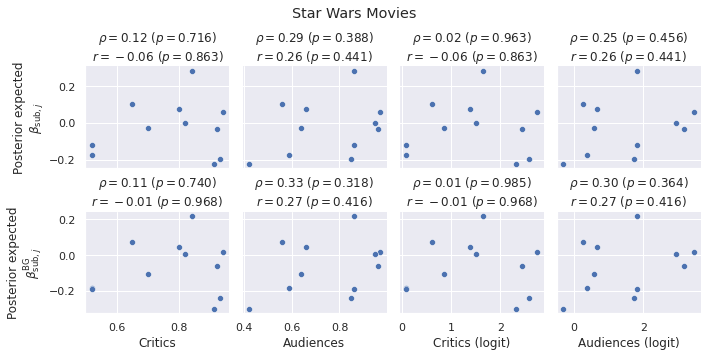

In [135]:
grid = sns.pairplot(
    movie_df,
    x_vars=REVIEW_SCORES, y_vars=POST_EFFECTS
)
grid.map(add_corr);

grid.axes[0, 0].set_ylabel("Posterior expected\n" + r"$\beta_{\mathrm{sub}, j}$");
grid.axes[1, 0].set_ylabel("Posterior expected\n" + r"$\beta_{\mathrm{sub}, j}^{\mathrm{BG}}$");

grid.fig.suptitle("Star Wars Movies");
grid.tight_layout();

This plot shows both the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) ($\rho$) and the [Spearman rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) ($r$) of the Critic and Audience scores (both standard and log-odds) and the posterior expected subtheme effects (both with and without the Bafumi-Gelman correction).  We see that these correlations tend to be weak and insignificant.

We produce a similar plot for Star Wars television shows below.

In [136]:
tv_df = pd.DataFrame.from_records(
    [("The Clone Wars", 0.93, 0.92),
     ("Rebels", 0.98, 0.82),
     ("The Mandalorian", 0.93, 0.91),
     ("Rebels", 0.92, 0.6),
     ("The Bad Batch", 0.88, 0.81)],
    columns=["Subtheme", "Critics", "Audiences"]
)

tv_df["post_mean"] = β_sub_post_mean.sel(sub=tv_df["Subtheme"].values)
tv_df["bg_post_mean"] = (full_trace.posterior["β_sub_bg"]
                                      .sel(sub=tv_df["Subtheme"].values)
                                      .mean(dim=("chain", "draw")))

tv_df["Critics (logit)"] = sp.special.logit(tv_df["Critics"])
tv_df["Audiences (logit)"] = sp.special.logit(tv_df["Audiences"])

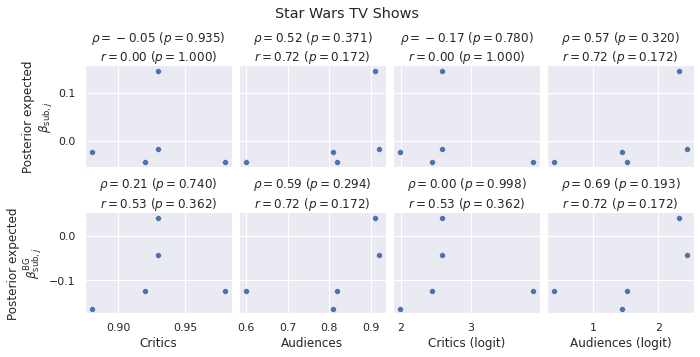

In [137]:
grid = sns.pairplot(
    tv_df,
    x_vars=REVIEW_SCORES, y_vars=POST_EFFECTS
)
grid.map(add_corr);

grid.axes[0, 0].set_ylabel("Posterior expected\n" + r"$\beta_{\mathrm{sub}, j}$");
grid.axes[1, 0].set_ylabel("Posterior expected\n" + r"$\beta_{\mathrm{sub}, j}^{\mathrm{BG}}$");

grid.fig.suptitle("Star Wars TV Shows");
grid.tight_layout();

It is interesting that the rank correlations here are much higher than for the movies above, but still not significant. (Of course as good Bayesians we take these p-values with a heap of salt.)

In the end we conclude that this model shows no evidence that the ratings of Star Wars sets are correlated with the entries in the Star Wars media franchise from which they are drawn.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/519788583f8caa5fcc942bcc2c9c422c).

In [138]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Mon Oct 25 2021

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.28.0

xarray    : 0.19.0
seaborn   : 0.11.2
scipy     : 1.7.1
pandas    : 1.3.3
pymc      : 4.0.0
arviz     : 0.11.4
numpy     : 1.19.5
aesara    : 2.2.2
networkx  : 2.5
matplotlib: 3.4.3

